In [302]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import entropy, norm, gamma, linregress, pearsonr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import seaborn as sns
import geopandas
import cmocean
import shapely
import matplotlib.ticker as tck
#import skbio
from scipy.special import gamma, hyp2f1

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

In [310]:
def log_hist(data, nbins=30):
    '''
    Function to calculate the log-histogram of a dataset. In particular, it calculates log-spaced bins, and then 
    calculates the counts, probability, and probability density of the data in those bins.
    
    Parameters
    ----------
    data : array-like
        Dataset to calculate the log-histogram of
    nbins : int
        Number of bins to use in the histogram
    
    Returns
    -------
    bins : array-like
        Log-spaced bins
    counts : array-like
        Counts in each bin (sum to total number of data points)
    prob : array-like  
        Probability of each bin (sum to 1)
    pdf : array-like   
        Probability density of each bin (the area sums to 1)
    '''
    
    bins = np.logspace(np.log10(data.min()), np.log10(data.max()), nbins)
    counts = np.histogram(data, bins=bins)[0]
    prob = counts / counts.sum()
    pdf = prob / np.diff(bins)
    
    return bins, counts, prob, pdf

def pdfES(n, alpha, beta, r):
    '''
    function to compute the pdf of the ES distribution
    
    Parameters
    ----------
    n: float
        abundance of the species
    alpha : float
        alpha parameter of the ES distribution
    beta : float
        beta parameter of the ES distribution
    r : float
        r parameter of the ES distribution
    
    Returns
    -------
    pdf : float
        pdf of the ES distribution
    '''
    term1 = gamma(beta + 2) * np.exp(r - n * r) * gamma(n + alpha)
    term2 = gamma(alpha + 1) * gamma(n + beta + 1) * hyp2f1(1, alpha + 1, beta + 2, np.exp(-r))
    return term1 / term2

In [4]:
sns.set(font='Avenir', font_scale=1.3, style='ticks')
#fig_dir = '/Users/emanuelepigani/Documents/tara/downscaling/fig/'
fig_dir = '../fig/'
figsize_geo = (10,7.5)

In [5]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

# Raw to clean

In [6]:
#filename = '/Users/emanuelepigani/Documents/tara/tara/woa_pisces_tarassd.tsv'
filename =  '../data/woa_pisces_tarassd.tsv'
df = pd.read_csv(filename, sep ='\t')
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="ESRI:54030")
gdf.head()

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0        7   37.0434     1.9493            SUR              9      9  727.0  \
1        8   38.0050     3.9899            SUR              9      9  717.0   
2       10   40.6541     2.8407            SUR              9      9  711.0   
3       11   41.6645     2.7983            SUR              9     10    NaN   
4       12   43.3482     7.9010            SUR              5     10  675.0   

    temp_woa    sal_woa   no3_woa   po4_woa  sioh4_woa      dco    dcu    dfe   
0  25.320400  37.243389  0.654349  0.171634   0.129361   55.321  1.129  2.158  \
1  25.628609  37.451500  0.212858  0.154929   0.584276   51.391  1.152  1.700   
2  24.797300  37.925713  0.072777  0.103806   0.451147   60.567  1.089  3.298   
3  21.630198  37.960928  0.007061  0.028331   0.065810   65.818  1.336  3.837   
4  20.361670  38.178169  0.006583  0.033686   0.089598  100.297  1.040  4.290   

     dzn              geometry  
0  3.596  POINT (1.949 37.043)  
1  3.868  POINT (3.990 38.005)  
2  3.197  POINT (2.841 40.654)  
3  4.457  POINT (2.798 41.664)  
4  2.368  POINT (7.901 43.348)

In [7]:
! pwd

/Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/HayMele Pigani et al 2023/downscaling/code


In [8]:
raw_file = '/Volumes/GoogleDrive/Il mio Drive/data/tara/downscaling/data/barv20161202_norm_swarm_d1_20_180.txt'
raw_file = '../data/raw_data.txt'
#abundance_file = '/Volumes/GoogleDrive/Il mio Drive/data/tara/downscaling/data/Abundance.csv'
abundance_file = '../data/Abundance.csv'
#Abundances = pd.read_csv(raw_file, sep=' ', index_col=0, header=0)
#Abundances.rename(columns = {c: c.split('_')[1]+'_'+c.split('_')[2] for c in Abundances.columns}, inplace=True)
#Abundances.to_csv(abundance_file)
Abundances = pd.read_csv(abundance_file, index_col=0, header=0)

Normalized_Abundances = Abundances/Abundances.sum(axis=0)

Depths = {d: [c for c in Abundances.columns if c[-3:]==d] for d in ['SRF','DCM']}
Stations = np.unique([int(c.split('_')[0]) for c in Abundances[Abundances.sum(axis=1)>0].columns])
print (' Number of stations: {} \n Number of different OTUs: {}'.format(len(Stations), len(Abundances)))
print ('\n Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(Depths['SRF']),len(Depths['DCM'])))

Abundances.head(3)

 Number of stations: 125 
 Number of different OTUs: 5830

 Number of stations SRF: 125 
 Number of stations DCM: 58


158_SRF  188_SRF  194_SRF  194_DCM  168_DCM   
0007584343baed6a66bc624ab07afa51        0        0        0        0        0  \
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        2        0        0   

                                  206_SRF  191_SRF  180_DCM  196_SRF  173_SRF   
0007584343baed6a66bc624ab07afa51        0        0        0        0        0  \
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        5        0        0        0        0   

                                  ...  150_DCM  150_SRF  151_DCM  151_SRF   
0007584343baed6a66bc624ab07afa51  ...        0        0        0        0  \
000d7f48a59463756281b4ea64af743f  ...        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a  ...        0        0        0        0   

                                  152_SRF  047_DCM  047_SRF  049_SRF  078_SRF   
0007584343baed6a66bc624ab07afa51        0        0        0        0        0  \
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        0        0        0   

                                  078_DCM  
0007584343baed6a66bc624ab07afa51        0  
000d7f48a59463756281b4ea64af743f        0  
001dedda63f65dd120ccef5ed9eff10a        0  

[3 rows x 183 columns]

In [9]:
for depth in Depths:
    gdf['station_{}'.format(depth)] = gdf['station'].apply(lambda x: '{0:s}_{1:s}'.format(str(x).zfill(3),depth) if '{}_{}'.format(str(x).zfill(3), depth) in Abundances.columns else np.nan) 
    gdf['TotAbundance_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: Abundances[x].sum(axis=0) if x in Abundances.columns else None)
    gdf['Richness_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: len(Abundances.loc[Abundances[x]>0]) if x in Abundances.columns else None)
    gdf['Shannon_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: entropy(Normalized_Abundances.loc[:,x]) if x in Abundances.columns else None)
    gdf['Evenness_{}'.format(depth)] = gdf['Shannon_{}'.format(depth)]/np.log(gdf['Richness_{}'.format(depth)])

# Geographical plot

## Stations with labels

In [10]:
def return_geo(x):
    if np.abs(x)>60:
        return 'polar'
    elif np.abs(x)>30:
        return 'tropical'
    else:
        return 'equatorial'

In [11]:
regions = {}
gdf['region'] = gdf['latitude'].apply(lambda x : return_geo(x))

In [12]:
gdf.head(3)

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0        7   37.0434     1.9493            SUR              9      9  727.0  \
1        8   38.0050     3.9899            SUR              9      9  717.0   
2       10   40.6541     2.8407            SUR              9      9  711.0   

    temp_woa    sal_woa   no3_woa  ...  TotAbundance_SRF  Richness_SRF   
0  25.320400  37.243389  0.654349  ...            7586.0          94.0  \
1  25.628609  37.451500  0.212858  ...             789.0          33.0   
2  24.797300  37.925713  0.072777  ...             189.0          22.0   

   Shannon_SRF  Evenness_SRF  station_DCM  TotAbundance_DCM Richness_DCM   
0     2.371901      0.522066      007_DCM            7133.0        115.0  \
1     2.119975      0.606312      008_DCM             676.0         49.0   
2     2.053981      0.664495      010_DCM             215.0         46.0   

  Shannon_DCM  Evenness_DCM    region  
0    2.545776      0.536525  tropical  
1    3.014191      0.774494  tropical  
2    3.153007      0.823532  tropical  

[3 rows x 28 columns]

(10, 7.5)


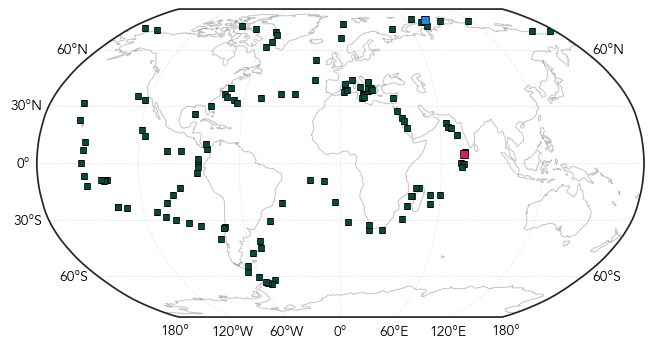

Figure dimension (inches):  [8. 4.]


In [423]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(8,4))
print(figsize_geo)
ax.set_global()
#ax.stock_img()

#ax.background_img(name='BM', resolution='low')
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

cmap = 'coolwarm'
#cmap = cmocean.cm.thermal 
colorcoded = False   
if colorcoded:
    gdf.plot(column="temp_woa", cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, marker='s',
            legend=False, alpha=0.9, lw=1, edgecolors='black', s=10,
            legend_kwds={'shrink': 0.6, 'pad':0.08,
                        'orientation': 'horizontal', 
                        'extend':'max', 
                        'label': 'Temperature [°C]'
                        })
else:
    gdf.loc[gdf['station'].isin([173])].plot(color='#1E88E5', transform = ccrs.Geodetic(), ax=ax, zorder=15, marker='s', lw=0.5, edgecolors='black', markersize=30)
    gdf.loc[gdf['station'].isin([43])].plot(color='#D81B60', transform = ccrs.Geodetic(), ax=ax, zorder=15, marker='s', lw=0.5, edgecolors='black', markersize=30)
    gdf.loc[~gdf['station'].isin([173, 43])].plot(color='#004D40', transform = ccrs.Geodetic(), ax=ax, zorder=10, marker='s', lw=0.5, edgecolors='black', markersize=15)

gdf['text_color'] = gdf['temp_woa'].apply(lambda x : 'white' if x<-80 else 'black')

text = False
if text:
    gdf.loc[gdf['station'].isin([43, 173])].apply(lambda x: ax.text(x.geometry.x+15, x.geometry.y, x.station, color=x.text_color,
                                horizontalalignment='right', verticalalignment='center',
                                transform = ccrs.Geodetic(), fontsize=12, zorder=11), axis=1
              )

plt.show()
print('Figure dimension (inches): ',fig.get_size_inches())
fig.savefig(fig_dir+'map.svg', transparent=True, bbox_inches='tight')

In [210]:
gdf.loc[gdf['station'].isin([173, 201])]


station  latitude  longitude depth_category  depth_nominal  month   
118      173   78.9564    79.4201            SUR              5      7  \
128      201   74.2987   -85.7806            SUR              5      9   

        SSD   temp_woa    sal_woa   no3_woa  ...  Richness_DCM  Shannon_DCM   
118  1440.0   1.118490  33.406387  0.057944  ...           NaN          NaN  \
128   662.5  19.076705  35.146294  0.792999  ...         577.0       2.3965   

     Evenness_DCM  region  DeltaS_SRF  DeltaS_DCM absolute_latitute   
118           NaN   polar    0.000000         NaN           78.9564  \
128      0.376936   polar   -0.034188   -0.060659           74.2987   

    absolute_latitude  absolute_DS  text_color  
118           78.9564     0.000000       black  
128           74.2987     0.034188       black  

[2 rows x 34 columns]

## Total Abundance

In [13]:
Min = np.min(Abundances[Abundances>0].min().values)
Max = np.max(Abundances[Abundances>0].max().values)


print ('Minimum abundance : {0:1.0f}'.format(Min))
print ('Maximum abundance : {0:1.0f}'.format(Max))

Minimum abundance : 1
Maximum abundance : 2324400


In [65]:
Tot = Abundances.sum().sum()
Tot

14758731

<AxesSubplot:>

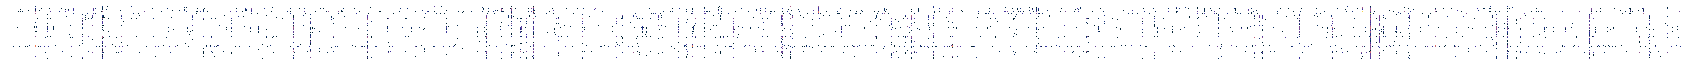

In [66]:
fig, ax = plt.subplots(figsize=(30,30))

sns.heatmap(Abundances[Abundances>0].T, cmap=cmocean.cm.thermal, 
            norm=clrs.LogNorm(vmin=np.min(Abundances[Abundances>0].min().values), 
                              vmax=np.max(Abundances[Abundances>0].max().values)),
           ax=ax, square=True, xticklabels=False, yticklabels=False, cbar=False)

#fig.savefig('/Users/emanuelepigani/Downloads/fig.png', dpi=500)
#fig.savefig(fig_dir + 'abundances.pdf')

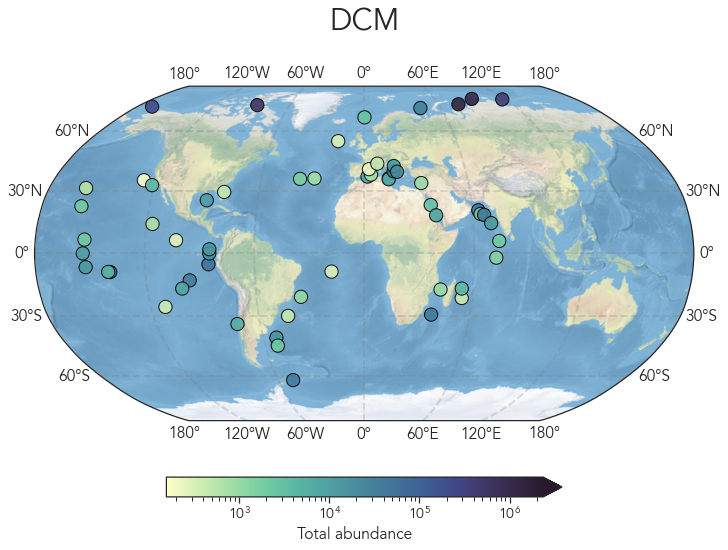

In [67]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=figsize_geo, constrained_layout=True)
ax.set_global()
ax.stock_img()
fig.suptitle('DCM', size=30)
#ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.25, linestyle='--')

column = "TotAbundance_DCM"
cbar = gdf.plot(column=column, cmap=cmocean.cm.deep, transform = ccrs.Geodetic(), ax=ax, zorder=10, 
                norm=clrs.LogNorm(vmin=gdf[column].min(), vmax=gdf["TotAbundance_SRF"].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=175,
                 legend_kwds={'shrink': 0.6, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      'extend':'max', "fmt": "{:1.0e}",
                      'label': 'Total abundance'
                     })

#fig.tight_layout()
fig.savefig(fig_dir + 'TotAb_DCM.pdf')

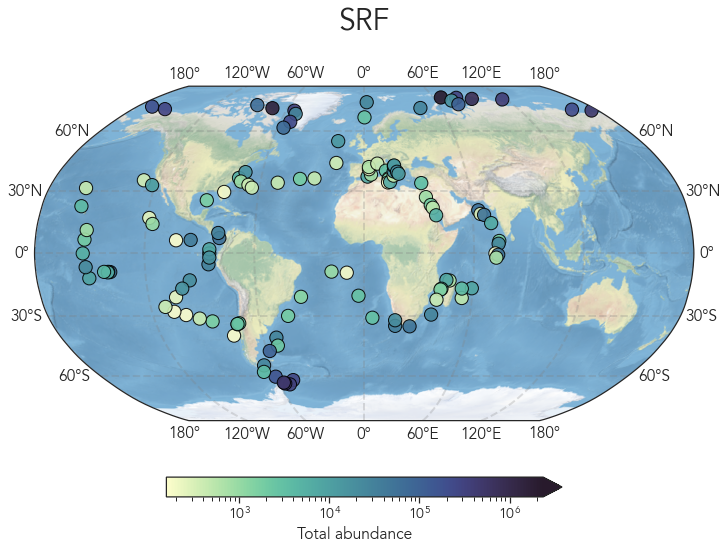

In [68]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=figsize_geo, constrained_layout=True)
ax.set_global()
ax.stock_img()
fig.suptitle('SRF', size=30)
#ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.25, linestyle='--')

column = "TotAbundance_SRF"
cbar = gdf.plot(column=column, cmap=cmocean.cm.deep, transform = ccrs.Geodetic(), ax=ax, zorder=10, 
                norm=clrs.LogNorm(vmin=gdf["TotAbundance_DCM"].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=175,
                 legend_kwds={'shrink': 0.6, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      'extend':'max', "fmt": "{:1.0e}",
                      'label': 'Total abundance'
                     })

fig.savefig(fig_dir + 'TotAb_SRF.pdf')

## Richness

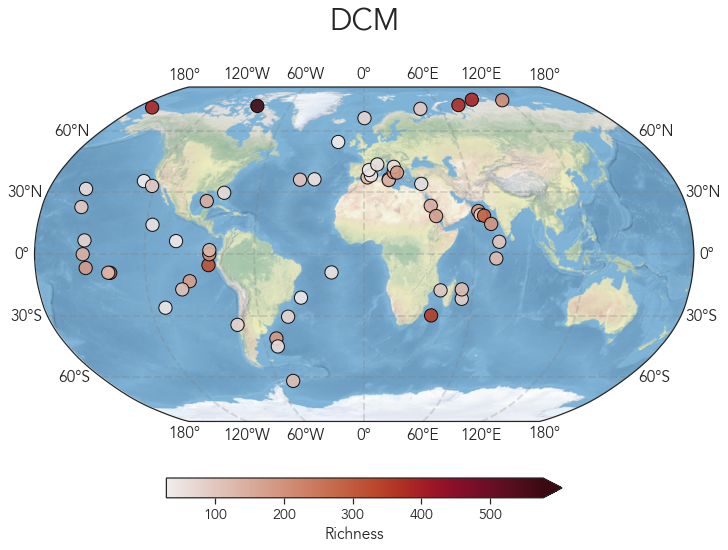

In [69]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=figsize_geo, constrained_layout=True)
ax.set_global()
ax.stock_img()
fig.suptitle('DCM', size=30)
#ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.25, linestyle='--')

column = "Richness_DCM"
cbar = gdf.plot(column=column, cmap=cmocean.cm.amp, transform = ccrs.Geodetic(), ax=ax, zorder=10,
                #norm=clrs.LogNorm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=175,
                 legend_kwds={'shrink': 0.6, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      'extend':'max', "fmt": "{:1.0e}",
                      'label': 'Richness'
                     })

fig.savefig(fig_dir + 'Rich_DCM.pdf')

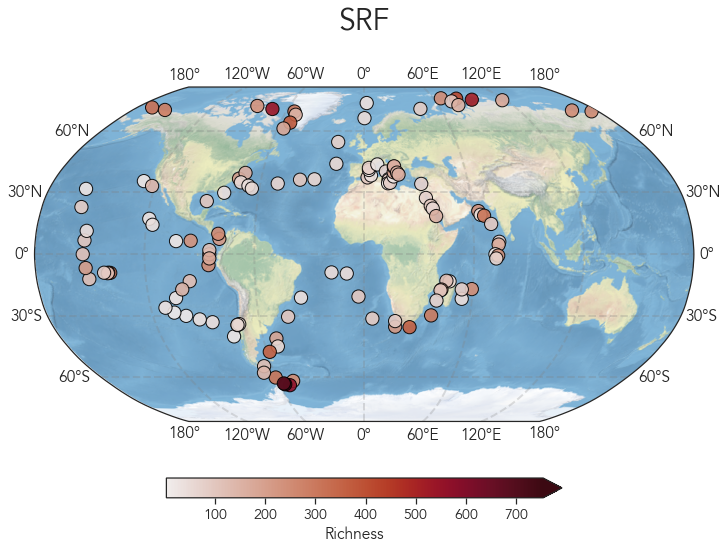

In [70]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=figsize_geo, constrained_layout=True)
ax.set_global()
ax.stock_img()
fig.suptitle('SRF', size=30)
#ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.25, linestyle='--')

column = "Richness_SRF"
cbar = gdf.plot(column=column, cmap=cmocean.cm.amp, transform = ccrs.Geodetic(), ax=ax, zorder=10, 
                #norm=clrs.LogNorm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=175,
                 legend_kwds={'shrink': 0.6, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      'extend':'max', "fmt": "{:1.0e}",
                      'label': 'Richness'
                     })

fig.savefig(fig_dir + 'Rich_SRF.pdf')

## Evenness

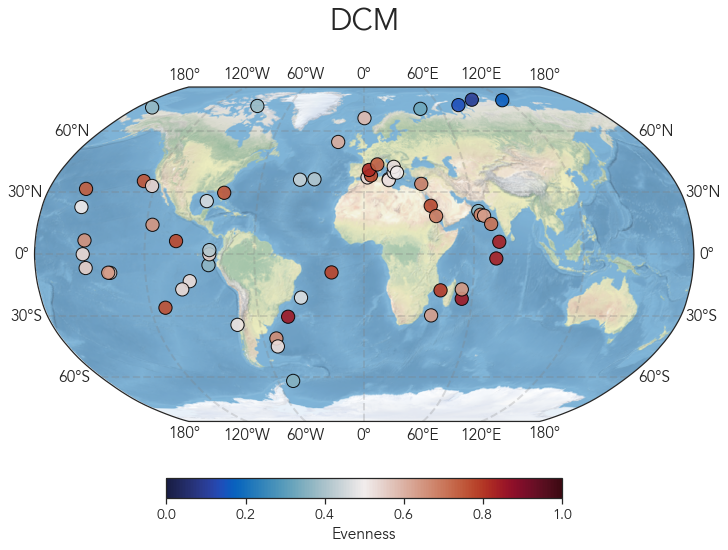

In [71]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=figsize_geo, constrained_layout=True)
ax.set_global()
ax.stock_img()
fig.suptitle('DCM', size=30)
#ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.25, linestyle='--')

column = "Evenness_DCM"
cbar = gdf.plot(column=column, cmap=cmocean.cm.balance, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=0, vmax=1,
                #norm=clrs.LogNorm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=175,
                 legend_kwds={'shrink': 0.6, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      #'extend':'max', 
                              "fmt": "{:1.0e}",
                      'label': 'Evenness'
                     })

fig.savefig(fig_dir + column + '.pdf')

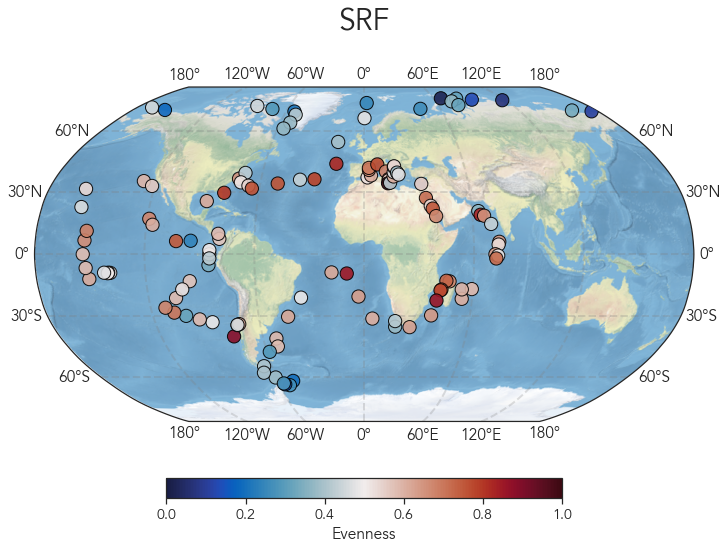

In [72]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=figsize_geo, constrained_layout=True)
ax.set_global()
ax.stock_img()
fig.suptitle('SRF', size=30)
#ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.25, linestyle='--')

column = "Evenness_SRF"
cbar = gdf.plot(column=column, cmap=cmocean.cm.balance,#cmocean.cm.deep, 
                transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=0, vmax=1,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=175,
                 legend_kwds={'shrink': 0.6, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      #'extend':'max',
                      "fmt": "{:1.0e}",
                      'label': 'Evenness'
                     })

fig.savefig(fig_dir + column + '.pdf')

# Grilli's analysis

## Taylor's law and MAD

In [73]:
sns.set(font='Avenir', font_scale=1.5, style='ticks')

In [74]:
Mean = Normalized_Abundances.mean(axis=1)
Var = Normalized_Abundances.var(axis=1)
LogMean = np.log10(Mean)
RescaledLogMean = (LogMean-LogMean.mean())/LogMean.std()

fit = linregress(np.log10(Mean), np.log10(Var))
print (fit)

### finding only the intercept
def func(x, k):
    return np.log10(k) + 2*x
popt, pcov = curve_fit(func, np.log10(Mean), np.log10(Var))
print (popt)

LinregressResult(slope=1.8636375420115645, intercept=1.1774023962886613, rvalue=0.9960863087870979, pvalue=0.0, stderr=0.002166145599084754, intercept_stderr=0.014111458189863441)
[112.08500188]


In [75]:
Mean.max()

0.0686366176692745

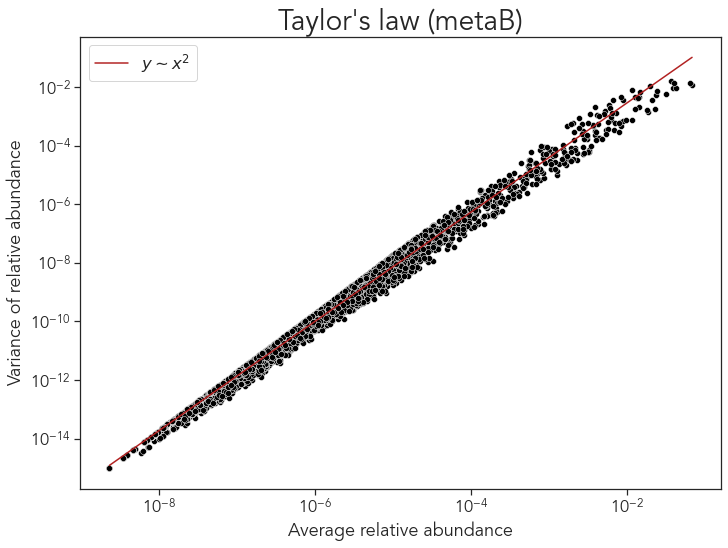

In [76]:
fig, ax = plt.subplots(figsize=figsize_geo, constrained_layout=True)
ax.set_title('Taylor\'s law (metaB)', size=28)

sns.scatterplot(x=Mean,y=Var, color='black', ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Average relative abundance')
ax.set_ylabel('Variance of relative abundance')

x_axis = np.linspace(Mean.min(), Mean.max(), 100)
y_axis = 10**fit.intercept * x_axis**fit.slope
#label = 'fit: {0:1.1f}'.format(fit.slope)
#ax.plot(x_axis, y_axis, color='firebrick', label=label)

y_axis2 = popt[0]*x_axis**2
ax.plot(x_axis, y_axis, color='firebrick', label=r'$y\sim x^{}$'.format(2))
ax.legend()
#fig.tight_layout()

fig.savefig(fig_dir + 'Taylor.pdf')

AttributeError: 'Normalize' object has no attribute 'pdf'

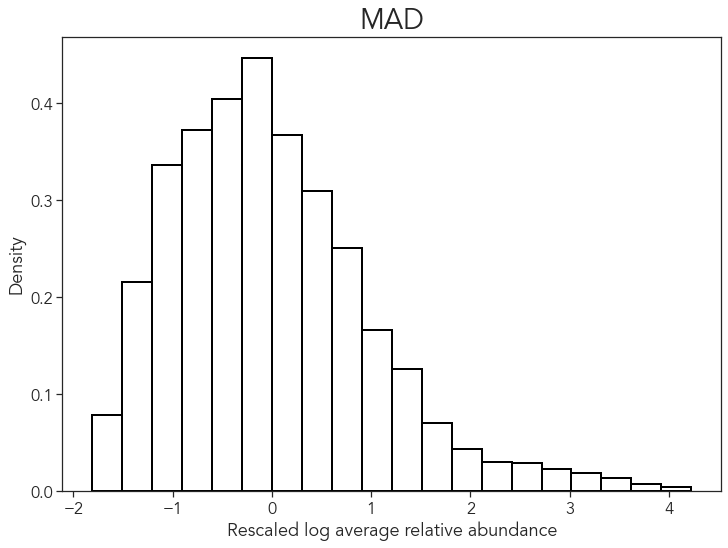

In [77]:
fig, ax = plt.subplots(figsize=figsize_geo, constrained_layout=True)
ax.set_title('MAD', size=28)

sns.histplot(x=RescaledLogMean, fill=False, element='bars', lw=2, stat='density', color='black', bins=20, log_scale=False, ax=ax)
ax.set_xlabel('Rescaled log average relative abundance')
#ax.set_yscale('log')
#ax.set_xlim([-2,2])

x_axis = np.linspace(RescaledLogMean.min(), RescaledLogMean.max(), 1000)
ax.plot(x_axis, norm.pdf(x_axis, 0., 1.), lw=2, color='firebrick', label='Lognormal')

ax.legend()
#fig.tight_layout()

fig.savefig(fig_dir + 'MAD.pdf')

## AFD

In [78]:
most_occurrent = np.argmax(((Normalized_Abundances>0)*1).sum(axis=1))
AFD = Normalized_Abundances.iloc[most_occurrent,:].values
AFD = AFD[AFD>0]
LogAFD = np.log10(AFD)
RescaledLogAFD = (LogAFD-LogAFD.mean())/LogAFD.std()

betaG = (LogAFD.mean()/LogAFD.std())**2
alphaP = betaG
betaP = betaG/AFD.mean()


In [79]:
alphaP, betaP

(3.650913200092299, 54.82850544211407)

In [80]:
x_axis = np.linspace(AFD.min(), AFD.max(), 1000)
y_axis = gamma.pdf(x_axis, alphaP, scale = 1/betaP)

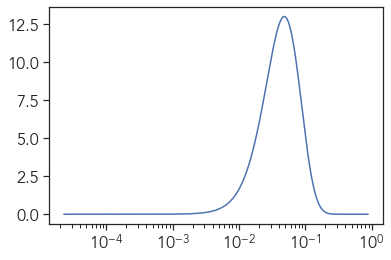

In [81]:
plt.plot(x_axis, y_axis)
plt.xscale('log')

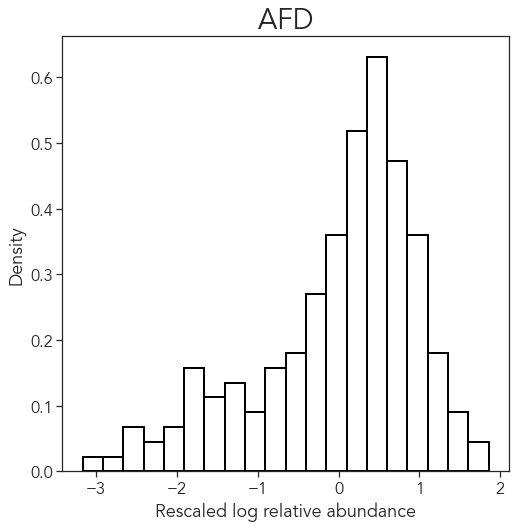

In [82]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('AFD', size=28)

sns.histplot(x=RescaledLogAFD, fill=False, element='bars', lw=2, stat='density', color='black', bins=20, log_scale=False, ax=ax)
ax.set_xlabel('Rescaled log relative abundance')

#ax.plot(np.log(x_axis), y_axis)

fig.savefig(fig_dir + 'AFD.pdf')

## Occupancy

In [ ]:
Occupancy = ((Abundances>0)*1).sum(axis=1).values/len(Abundances.columns)

In [ ]:
fig, ax = plt.subplots(figsize=figsize_geo, constrained_layout=True)
ax.set_title('Occupancy (metaB)', size=28)

sns.histplot(x=Occupancy, fill=False, element='bars', lw=2, stat='probability', color='black',bins=30, log_scale=False, ax=ax)
ax.set_xlabel('$o$')
ax.set_ylabel('$P(o)$')
ax.set_yscale('log')

#ax.plot(np.log(x_axis), y_axis)

fig.savefig(fig_dir + 'Occupancy.pdf')

## Occurence vs Abundance

In [ ]:
abds = Normalized_Abundances[(Abundances>0)].sum(axis=1).values

In [ ]:
fig, ax = plt.subplots(figsize=figsize_geo, constrained_layout=True)
ax.set_title('Abundance vs Occurrence', size=28)
ax.set_xscale('log')
ax.set_yscale('log')

sns.scatterplot(x=Occurrences, y=abds, color='black', ax=ax)

# SAD

## 173

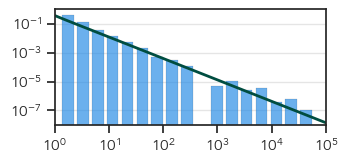

In [367]:
data173 = Abundances['173_SRF']
data173 = data173[data173>0].values
bins, counts, prob, pdf = log_hist(data173, nbins=20)

fig, ax = plt.subplots(figsize=(3.5,1.5))
widths = np.diff(bins)
x = np.sqrt(bins[:-1] * bins[1:])
ax.bar(x, pdf, width=widths, align='edge', color='#1E88E5', linewidth=0.1, edgecolor='black', alpha=0.66)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.set_yticks([1e-7, 1e-5, 1e-3, 1e-1])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
ax.set_xlim(1e0, 1e5)
ax.set_ylim(1e-8, 1e0)
ax.grid(axis='y', alpha=0.5)

xlist = [1.,1.25893,1.58489,1.99526,2.51189,3.16228,3.98107,5.01187,6.30957,7.94328,10.,12.5893,15.8489,19.9526,25.1189,31.6228,39.8107,50.1187,63.0957,79.4328,100.,125.893,158.489,199.526,251.189,316.228,398.107,501.187,630.957,794.328,1000.,1258.93,1584.89,1995.26,2511.89,3162.28,3981.07,5011.87,6309.57,7943.28,10000.,12589.3,15848.9,19952.6,25118.9,31622.8,39810.7,50118.7,63095.7,79432.8,100000.]
y = [
    0.378238, 0.265262, 0.187236, 0.132661, 0.0941934, 0.0669551,
    0.0476181, 0.0338716, 0.024093, 0.0171356, 0.0121854, 0.00866378,
    0.00615899, 0.00437775, 0.00311128, 0.00221097, 0.00157105,
    0.00111626, 0.000793078, 0.000563438, 0.000400276, 0.000284354,
    0.000201999, 0.000143493, 0.00010193, 0.0000724056, 0.0000514323,
    0.000036534, 0.000025951, 0.0000184336, 0.0000130938, 9.30072e-6,
    6.60645e-6, 4.69265e-6, 3.33325e-6, 2.36765e-6, 1.68177e-6,
    1.19458e-6, 8.48522e-7, 6.02713e-7, 4.28113e-7, 3.04093e-7,
    2.16e-7, 1.53427e-7, 1.0898e-7, 7.74098e-8, 5.49848e-8, 3.90562e-8,
    2.7742e-8, 1.97054e-8, 1.39969e-8
]

sns.lineplot(x=xlist,y=y, color='#004D40', ax=ax, lw=2)
fig.savefig(fig_dir + '173_SRF.svg', transparent=True, bbox_inches='tight')

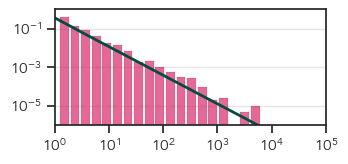

In [368]:
data43 = Abundances['043_SRF']
data43 = data43[data43>0].values
bins, counts, prob, pdf = log_hist(data43, nbins=20)

fig, ax = plt.subplots(figsize=(3.5,1.5))
widths = np.diff(bins)
x = np.sqrt(bins[:-1] * bins[1:])
ax.bar(x, pdf, width=widths, align='edge', color='#D81B60', linewidth=0.1, edgecolor='black', alpha=0.66)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.set_yticks([1e-7, 1e-5, 1e-3, 1e-1])
ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
ax.set_xlim(1e0, 1e5)
ax.set_ylim(1e-6, 1e0)
ax.grid(axis='y', alpha=0.5)

xlist = [1., 3.16228, 10., 31.6228, 100., 316.228, 1000, 3162.28, 1e4]
y = [0.366351, 0.0642375, 0.0116215, 0.00210342, 0.000380473, 0.000380473*np.exp(-1.70990465), 0.000380473*np.exp(-2*1.70990465), 0.000380473*np.exp(-3*1.70990465), 0.000380473*np.exp(-4*1.70990465)]
sns.lineplot(x=xlist,y=y, color='#004D40', ax=ax, lw=2)
fig.savefig(fig_dir + '43_SRF.svg', transparent=True, bbox_inches='tight')

## All together

In [13]:
SAD = Abundances.sum(axis=1).values
print ('Richness: {}'.format(len(SAD)))

Richness: 5830


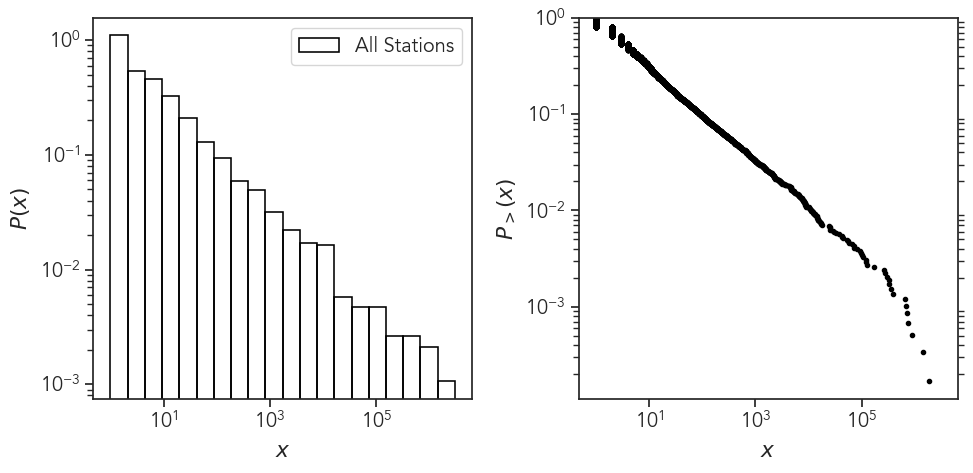

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
#fig.suptitle('{}'.format(col), size=20)

ax = axes[0]
label = 'All Stations'
# facecolor='grey', 
sns.histplot(x=SAD, element='bars', lw=1.5, stat='density', color='black', fill=False,  bins=20, log_scale=True, ax=ax, label =label)
ax.set_xlabel('$x$')
ax.set_ylabel('$P(x)$')
ax.set_yscale('log')
ax.legend()

ax = axes[1]
sns.ecdfplot(x=SAD, complementary=True, color='black', log_scale=True, ax=ax, marker='.', ls='')
ax.set_xlabel('$x$')
ax.set_ylabel('$P_>(x)$')
ax.set_yscale('log')
ax.tick_params('both', which='minor', right='off')

fig.tight_layout()

#fig.savefig(fig_dir + 'SAD_all.pdf')


In [22]:
Abundances.head()

158_SRF  188_SRF  194_SRF  194_DCM  168_DCM   
0007584343baed6a66bc624ab07afa51        0        0        0        0        0  \
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        2        0        0   
002590d1d8d94af8dfcf5980c719d116        0        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01        0        0        0        0        0   

                                  206_SRF  191_SRF  180_DCM  196_SRF  173_SRF   
0007584343baed6a66bc624ab07afa51        0        0        0        0        0  \
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        5        0        0        0        0   
002590d1d8d94af8dfcf5980c719d116        0        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01        0        0        0        0        0   

                                  ...  150_DCM  150_SRF  151_DCM  151_SRF   
0007584343baed6a66bc624ab07afa51  ...        0        0        0        0  \
000d7f48a59463756281b4ea64af743f  ...        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a  ...        0        0        0        0   
002590d1d8d94af8dfcf5980c719d116  ...        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01  ...        0        0        0        0   

                                  152_SRF  047_DCM  047_SRF  049_SRF  078_SRF   
0007584343baed6a66bc624ab07afa51        0        0        0        0        0  \
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        0        0        0   
002590d1d8d94af8dfcf5980c719d116        0        0        0        0        0   
00374edaf2b110b52ffe3daea3626d01        0        0        0        0        0   

                                  078_DCM  
0007584343baed6a66bc624ab07afa51        0  
000d7f48a59463756281b4ea64af743f        0  
001dedda63f65dd120ccef5ed9eff10a        0  
002590d1d8d94af8dfcf5980c719d116        0  
00374edaf2b110b52ffe3daea3626d01        0  

[5 rows x 183 columns]

In [26]:
gdf.head()

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0        7   37.0434     1.9493            SUR              9      9  727.0  \
1        8   38.0050     3.9899            SUR              9      9  717.0   
2       10   40.6541     2.8407            SUR              9      9  711.0   
3       11   41.6645     2.7983            SUR              9     10    NaN   
4       12   43.3482     7.9010            SUR              5     10  675.0   

    temp_woa    sal_woa   no3_woa  ...  station_SRF  TotAbundance_SRF   
0  25.320400  37.243389  0.654349  ...      007_SRF            7586.0  \
1  25.628609  37.451500  0.212858  ...      008_SRF             789.0   
2  24.797300  37.925713  0.072777  ...      010_SRF             189.0   
3  21.630198  37.960928  0.007061  ...      011_SRF             651.0   
4  20.361670  38.178169  0.006583  ...      012_SRF             402.0   

   Richness_SRF  Shannon_SRF  Evenness_SRF  station_DCM TotAbundance_DCM   
0          94.0     2.371901      0.522066      007_DCM           7133.0  \
1          33.0     2.119975      0.606312      008_DCM            676.0   
2          22.0     2.053981      0.664495      010_DCM            215.0   
3          81.0     3.063462      0.697121          NaN              NaN   
4          24.0     2.450181      0.770969      012_DCM            457.0   

  Richness_DCM  Shannon_DCM  Evenness_DCM  
0        115.0     2.545776      0.536525  
1         49.0     3.014191      0.774494  
2         46.0     3.153007      0.823532  
3          NaN          NaN           NaN  
4         50.0     2.877567      0.735570  

[5 rows x 27 columns]

In [28]:
int(Abundances.columns[0].split('_')[0])

158

In [30]:
gdf.set_index('station', inplace=False).loc[7, 'temp_woa']

25.3204002380371

In [45]:
for col in Abundances.columns:
    try:
        station = int(col.split('_')[0])
        colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
        
    except:
        print(col)
        print (station)
        print(colorindex)

050_SRF
50
30


In [94]:
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,8*cms)
print(figsize)

(5.096172795238579, 3.149608)


/var/folders/c6/wyfkjjbx7951r06nx266f2z80000gn/T/ipykernel_53391/1102623779.py:28: RuntimeWarning: divide by zero encountered in divide
  pdf = prob / np.diff(bins)
/var/folders/c6/wyfkjjbx7951r06nx266f2z80000gn/T/ipykernel_53391/1102623779.py:28: RuntimeWarning: invalid value encountered in divide
  pdf = prob / np.diff(bins)


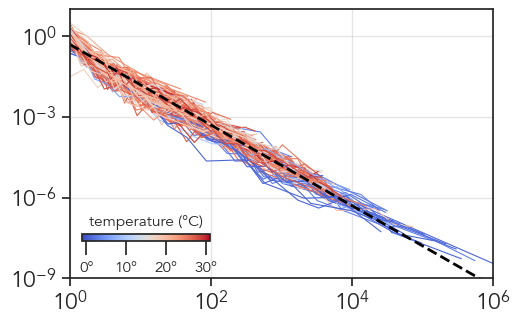

In [134]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
palettename = 'coolwarm'
#palettename = 'RdYlBu_r'
palette = sns.color_palette(palettename, 32)
ax.set_xscale('log')
ax.set_yscale('log')

for col in Abundances.columns:
    data = Abundances[col].values
    # log histogram
    bins, counts, prob, pdf = log_hist(data[data>0], nbins=20)
    station = int(col.split('_')[0])
    if station != 50:
        colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
        color = palette[colorindex]
        x = bins[:-1]
        x = x[pdf>0]
        y = pdf[pdf>0]
    #color='blue'
        sns.lineplot(x=x, y=y, ax=ax, color=color, lw=.8, ls='-', alpha=1, zorder=1)
        
cax = fig.add_axes([0.15, 0.25, 0.25, 0.025])
cax.tick_params(labelsize=10, size=10)
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(1e0, 1e6)
ax.set_ylim(1e-9, 1e1)
#ax.set_xlabel('n [#OTU]')
#ax.set_ylabel('P(n)')

# plot a powerlaw distribution with alpha=1.5
x = np.logspace(0, 6, 100)
alpha_pl = 0.5
y = alpha_pl * x**(-1-alpha_pl)

sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1)

fig.savefig(fig_dir + 'fig1a_SAD_all_collapsed.pdf')
fig.savefig(fig_dir + 'fig1a_SAD_all_collapsed.svg')

## Maximum likelihood fit of the SAD with a power law distribution

In [370]:
# import Kolmogorov-Smirnov test for goodness of fit
from scipy.stats import ks_2samp, kstest

In [371]:
# for each station, we use a maximum likelihood fit to a power law distribution to estimate the exponent
# the maximum likelihood estimator is the inverse of the mean of the log of the data

def maximum_likelihood_exponent(data):
    '''
    This function returns the maximum likelihood exponent of a power law distribution.
    The power law distribution is defined as:
    y = x**(-alpha-1)
    ----------
    Parameters
    data: array-like
        The data to fit. If some values are zero, they are removed.
    ----------
    Returns
    alpha: float
        The maximum likelihood exponent of the power law distribution
    pvalue: float
        The p-value of the Kolmogorov-Smirnov test
    '''
    alpha = 1/np.mean(np.log(data[data>0]))
    # calculate the p-value of the Kolmogorov-Smirnov test
    KS = kstest(data, 'powerlaw', args=(alpha,))
    pvalue = KS.pvalue
    
    return alpha, pvalue

In [372]:
# iterate over stations and compute the maximum likelihood exponent for each
alpha_dict = {}
pvalues_dict = {}
for col in Abundances.columns:
    data = Abundances[col].values
    station = int(col.split('_')[0])
    if station != 50:
        alpha, pvalue = maximum_likelihood_exponent(data[data>0])
        #print('Station {}: alpha = {}'.format(station, alpha))
        alpha_dict[station] = alpha+1
        pvalues_dict[station] = pvalue

/var/folders/c6/wyfkjjbx7951r06nx266f2z80000gn/T/ipykernel_53391/3745998438.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = 1/np.mean(np.log(data[data>0]))


In [18]:
alpha_val = np.array(list(alpha_dict.values()))
alpha_val = alpha_val[alpha_val>0]
alpha_val = alpha_val[alpha_val<10]
print(np.mean(alpha_val))
# define geometric mean function
def gmean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))
print(gmean(alpha_val))


1.7049856323994537
1.6936402123713818


In [375]:
print(pvalues_dict.values())

dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])


Mean exponent: inf


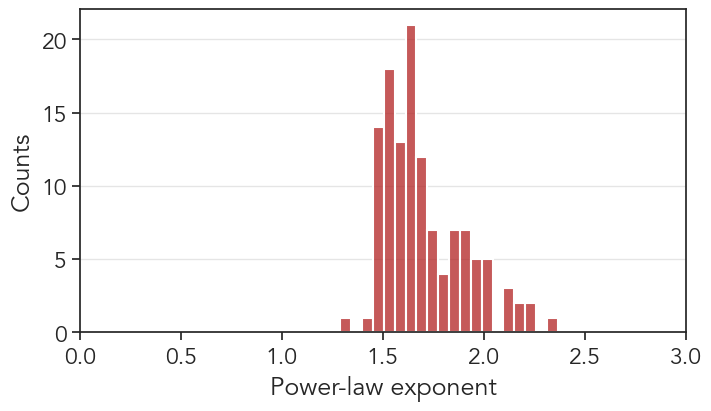

In [483]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)

# histogram of the maximum likelihood exponents
sns.histplot(x=alpha_dict.values(), element='bars', lw=1.5, stat='count', color='firebrick', fill=True,  bins=20, log_scale=False, ax=ax)
ax.set_xlim(0, 3)
ax.set_xlabel('Power-law exponent')
ax.set_ylabel('Counts')
ax.grid(True, which='major', axis='y', alpha=0.5, zorder=0)

print('Mean exponent: {}'.format(np.mean(list(alpha_dict.values()))))
fig.savefig(fig_dir + 'lambdaMLhisto.pdf')

In [476]:
gdf.head()

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0        7   37.0434     1.9493            SUR              9      9  727.0  \
1        8   38.0050     3.9899            SUR              9      9  717.0   
2       10   40.6541     2.8407            SUR              9      9  711.0   
3       11   41.6645     2.7983            SUR              9     10    NaN   
4       12   43.3482     7.9010            SUR              5     10  675.0   

    temp_woa    sal_woa   no3_woa  ...  text_color  lambda_SRF  alpha_SRF   
0  25.320400  37.243389  0.654349  ...       black    1.328576  -0.463369  \
1  25.628609  37.451500  0.212858  ...       black    1.366194   0.020669   
2  24.797300  37.925713  0.072777  ...       black    1.285189  -0.500000   
3  21.630198  37.960928  0.007061  ...       black    1.859758   0.314928   
4  20.361670  38.178169  0.006583  ...       black    1.421328   1.946502   

   beta_SRF     r_SRF  lambda_DCM alpha_DCM  beta_DCM     r_DCM  lambda_SRF_ML  
0 -0.134793  0.000000    1.406372 -0.196746  0.209626  0.000000       1.614192  
1  0.386863  0.000000    1.103913  0.030260  0.134172  0.011315       1.605167  
2 -0.214811  0.001499    1.952869  0.445389  1.398258  0.000000       1.909813  
3  1.174687  0.000000         NaN       NaN       NaN       NaN       1.971472  
4  2.367830  0.000000    1.282857 -0.500000 -0.217143  0.000000       1.514028  

[5 rows x 43 columns]

(10, 7.5)


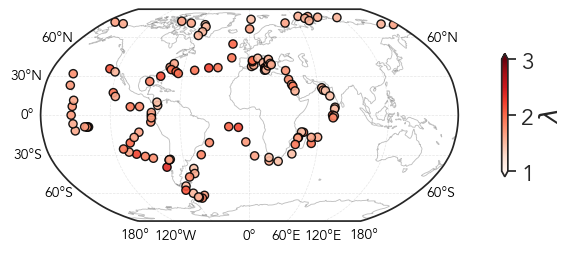

In [486]:
gdf['lambda_SRF_ML'] = gdf['station'].apply(lambda x: alpha_dict[x] if x in alpha_dict.keys() else np.nan)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
print(figsize_geo)
ax.set_global()
#ax.stock_img()

#ax.background_img(name='BM', resolution='low')
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "lambda_SRF_ML"
cmap = "Reds"
#cmap = cmocean.cm.balance
cbar = gdf.plot(column=column, transform = ccrs.Geodetic(), ax=ax, zorder=10, cmap=cmap, vmin=1., vmax=3.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\lambda$'
                     })

fig.savefig(fig_dir + 'lambdaMLdistribution.pdf', dpi=300 , facecolor='none', edgecolor='none', bbox_inches='tight', transparent=True)


## Sampling effects

In [98]:
# mock sads obtained by sampling from the observed distribution

reference_station_name = '173_SRF'
data = Abundances[reference_station_name].values
data = data[data>0]

total_abundance = np.sum(data)
print('Total abundance: {}'.format(total_abundance))
print('Number of OTUs: {}'.format(len(data)))

# generate a vector of probabilities for each OTU. The probability of each OTU is proportional to its abundance.
probabilities = data/total_abundance


sampling_efforts = []
richnesses_observed = []
multisamples = []
richnesses = []
colors = []
temperatures = []

for col in Abundances.columns:
    station = int(col.split('_')[0])
    if ((station != 50) and (np.sum(Abundances[col].values) >= 100)):
        sampling_efforts.append(np.sum(Abundances[col].values))
        richnesses_observed.append(len(Abundances[col].values[Abundances[col].values>0]))
        multisamples.append(np.random.multinomial(sampling_efforts[-1], probabilities))
        richnesses.append(len(multisamples[-1][multisamples[-1]>0]))
        colorindex = 1+int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
        tempereature = int(gdf.set_index('station', inplace=False).loc[station, 'temp_woa'])
        temperatures.append(tempereature)
        colors.append(palette[colorindex])


Total abundance: 312215
Number of OTUs: 422


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


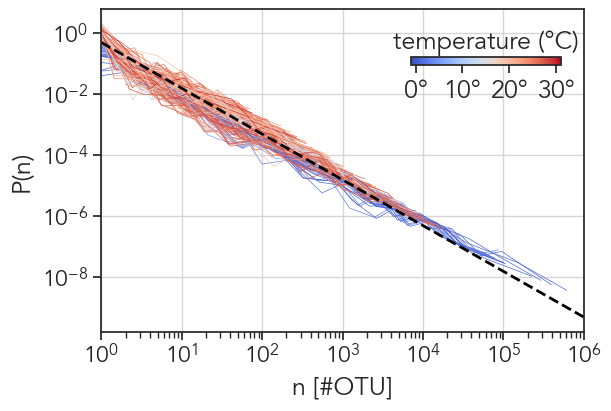

In [131]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

for i, sample in enumerate(multisamples):
    sample = sample[sample>0]
    bins, counts, prob, pdf = log_hist(sample, nbins=20)
    x = bins[:-1]
    y = pdf
    x = x[y>0]
    y = y[y>0]
    sns.lineplot(x=x, y=y, ax=ax, lw=.5, ls='-', alpha=1, zorder=1, color=colors[i])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.8, zorder=0)
ax.set_xlim(1e0, 1e6)
# sohw legend on the right
ax.set_xlabel('n [#OTU]')
ax.set_ylabel('P(n)')
# don't show legend
ax.legend().set_visible(False)

cax = fig.add_axes([0.675, 0.85, 0.25, 0.02])
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir')
cbar.ax.set_title('temperature (°C)', fontsize=12, font='Avenir')

# plot a powerlaw distribution with alpha=1.5
x = np.logspace(0, 6, 100)
alpha_pl = 0.5
y = alpha_pl * x**(-1-alpha_pl)

sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1)
fig.savefig(fig_dir + 'mock_SADs_{}.png'.format(reference_station_name), dpi=300, bbox_inches='tight')

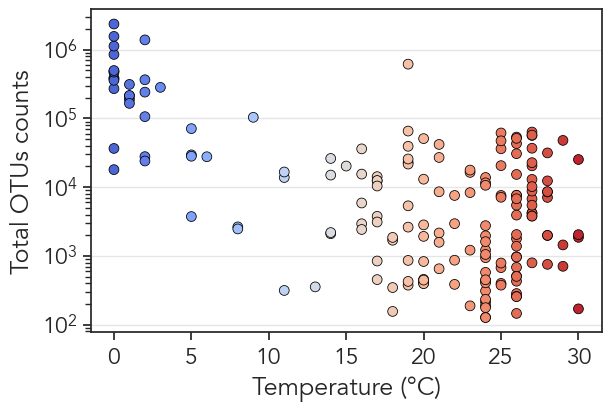

In [100]:
fig, ax = plt.subplots(figsize=(6,4), constrained_layout=True)

sns.scatterplot(x=temperatures, y=sampling_efforts,  ax=ax, s=50, color=colors, alpha=1, zorder=1, lw=0.05, edgecolor='black')
ax.set_yscale('log')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Total OTUs counts')
ax.grid(True, which='major', axis='y', alpha=0.5, zorder=0)

422
Pearson correlation coefficient: 0.8323329704470905
r^2: 0.6927781736932773
p-value: 1.0978812265184679e-45


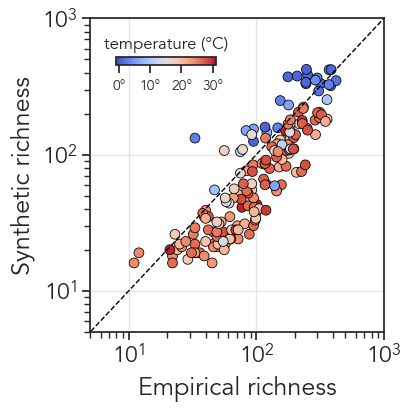

In [101]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

x = np.array (richnesses_observed)
y = np.array(richnesses)
max_y = np.max(y)
print(max_y)
y = y[x<=max_y]
cs = np.array(colors)[x<=max_y]
x = x[x<=max_y]

# calculate correlation coefficient and p-value between observed and synthetic richnesses
r, p = pearsonr(x, y)
print('Pearson correlation coefficient: {}'.format(r))
print('r^2: {}'.format(r**2))
print('p-value: {}'.format(p))


sns.scatterplot(x=x, y=y, ax=ax, s=50, color=cs, alpha=1, zorder=1, lw=0.1, edgecolor='black')
ax.set_xlabel('Empirical richness')
ax.set_ylabel('Synthetic richness')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(5*1e0, 1e3)
ax.set_ylim(5*1e0, 1e3)

cax = fig.add_axes([0.275, 0.85, 0.25, 0.02])
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=10)
cbar.ax.set_title('temperature (°C)', font='Avenir')
# change size of the colorbar title
cbar.ax.title.set_fontsize(12)

# draw a 1:1 line
ax.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

fig.savefig(fig_dir + 'mock_richnesses_{}.png'.format(reference_station_name), dpi=300, bbox_inches='tight')

In [103]:
print(fig_dir)

../fig/


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


422
Pearson correlation coefficient: 0.8323329704470905
r^2: 0.6927781736932773
p-value: 1.0978812265184679e-45
(1.6541269038832264e-10, 6.129072555368375)


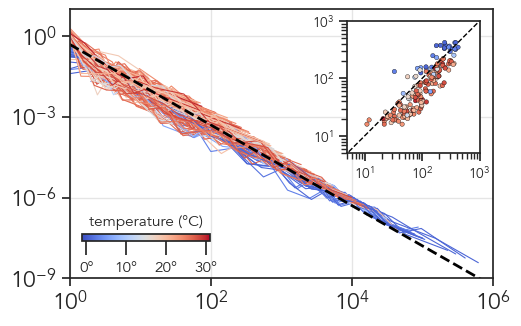

In [125]:
fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

for i, sample in enumerate(multisamples):
    sample = sample[sample>0]
    bins, counts, prob, pdf = log_hist(sample, nbins=20)
    x = bins[:-1]
    y = pdf
    x = x[y>0]
    y = y[y>0]
    sns.lineplot(x=x, y=y, ax=ax, lw=.8, ls='-', alpha=1, zorder=1, color=colors[i])
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(1e0, 1e6)
ax.set_ylim(1e-9, 1e1)
# sohw legend on the right
#ax.set_xlabel('n [#OTU]')
#ax.set_ylabel('P(n)')
# don't show legend
ax.legend().set_visible(False)

#cax2 = fig.add_axes([0.63, 0.63, 0.3, 0.3])
ratio = figsize[0]/figsize[1]
cax2 = fig.add_axes([0.67, 0.53, 0.42/ratio, 0.42])
# add axes with default font size 10
cax2.tick_params(labelsize=10, zorder=100)
cax = fig.add_axes([0.15, 0.25, 0.25, 0.025])
cax.tick_params(labelsize=10, size=10)
sm = plt.cm.ScalarMappable(cmap=palettename, norm=plt.Normalize(vmin=-1, vmax=31))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, ticks=[0., 10., 20., 30.], orientation='horizontal')#, fraction=0.026, pad=-0.2)
cbar.ax.set_xticklabels(['0°', '10°', '20°', '30°'],  font='Avenir', fontsize=11)
cbar.ax.set_title('temperature (°C)', font='Avenir', fontsize=11)

# plot a powerlaw distribution with alpha=1.5
x = np.logspace(0, 6, 100)
alpha_pl = 0.5
y = alpha_pl * x**(-1-alpha_pl)

sns.lineplot(x=x, y=y, ax=ax, color='black', lw=2., ls='--', alpha=1, zorder=1)


x = np.array (richnesses_observed)
y = np.array(richnesses)
max_y = np.max(y)
print(max_y)
y = y[x<=max_y]
cs = np.array(colors)[x<=max_y]
x = x[x<=max_y]

# calculate correlation coefficient and p-value between observed and synthetic richnesses
r, p = pearsonr(x, y)
print('Pearson correlation coefficient: {}'.format(r))
print('r^2: {}'.format(r**2))
print('p-value: {}'.format(p))

sns.scatterplot(x=x, y=y, ax=cax2, s=10, color=cs, alpha=1, zorder=1, lw=0.1, edgecolor='black')
# set xlabel and align to the right
#cax2.set_xlabel('empirical', fontsize=10, ha='left')
#cax2.set_ylabel('synthetic', fontsize=10, ha='left')
cax2.set_xscale('log')
cax2.set_yscale('log')
#cax2.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
cax2.set_xlim(5*1e0, 1e3)
cax2.set_ylim(5*1e0, 1e3)
# set xticks and yticks with the same fontsize with
#cax2.set_xticklabels(cax2.get_xticks(), fontsize=11)
#cax2.set_yticklabels(cax2.get_yticks(), fontsize=11)



# draw a 1:1 line
cax2.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

fig.savefig(fig_dir + 'fig1b_mock_SADs_{}.png'.format(reference_station_name), dpi=300, bbox_inches='tight')
fig.savefig(fig_dir + 'fig1b_mock_SADs_{}.svg'.format(reference_station_name), dpi=300, bbox_inches='tight')

In [115]:
! pwd

/Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/HayMele Pigani et al 2023/downscaling/code


In [25]:
# define SAR (cf Azaele et al. 2016)

def SAR(p, Sref, dataref):
    '''
    Function that calculates the expected number of species in a sample of size p, given a reference sample of size Sref with abundances dataref.
    Parameters
    ----------
    p: float
        The sample size fraction with respect to the reference sample. It must be between 0 and 1.
    Sref: int
        The number of species in the reference sample.
    dataref: array-like
        The abundances of the species in the reference sample. It must be of length Sref.
        
    Returns
    -------
    Sloc: float
        The expected number of species in the sample of size p.
    '''
    # assert that p is between 0 and 1 and that dataref is of length Sref
    assert (p>=0) and (p<=1), 'p must be between 0 and 1'
    assert len(dataref)==Sref, 'dataref must be of length Sref'
    
    Sloc = Sref - np.sum([(1-p)**dataref[i] for i in range(Sref)])
    return Sloc

In [33]:
reference_station_name = '209_SRF'
dataref = Abundances[reference_station_name].values
dataref = dataref[dataref>0]
Nref = np.sum(dataref)
Sref = len(dataref)

In [34]:
p = np.logspace(-5, 0, 100)
Sloc = [SAR(p, Sref, dataref) for p in p]

(10.0, 1000.0)

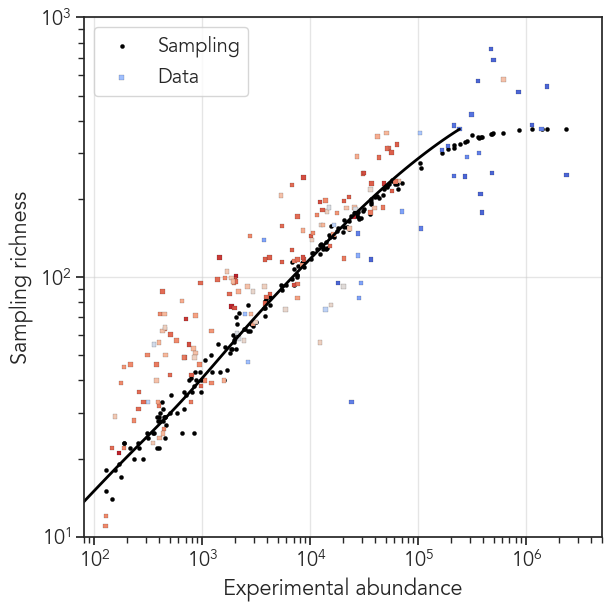

In [35]:
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)

sns.scatterplot(x=sampling_efforts, y=richnesses, ax=ax, s=10, color='black', linewidth=0.1, edgecolor='black', alpha=1, zorder=1, label='Sampling')
sns.scatterplot(x=sampling_efforts, y=richnesses_observed, ax=ax, s=10, color=colors, linewidth=0.1, edgecolor='black', alpha=1, zorder=1, marker='s', label='Data')
sns.lineplot(x=p*Nref, y=Sloc, ax=ax, color='black', lw=2., ls='-', alpha=1, zorder=1)
ax.set_xlabel('Experimental abundance')
ax.set_ylabel('Sampling richness')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)
ax.set_xlim(0.8*1e2, 5*1e6)
ax.set_ylim(1e1, 1e3)

## Station with the highest richness

In [83]:
col = Normalized_Abundances.columns[((Normalized_Abundances>0)*1).sum(axis=0).argmax()]
rich = len(Normalized_Abundances.loc[Normalized_Abundances[col]>0, col])
print ('Station with the highest richness: {}. Richness: {}'.format(col, rich))

Station with the highest richness: 087_SRF. Richness: 754


In [84]:
SAD = Normalized_Abundances[col].values
SAD = SAD[SAD>0]

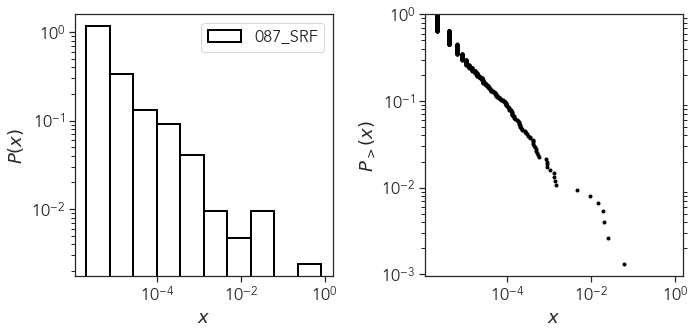

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
#fig.suptitle('{}'.format(col), size=20)

ax = axes[0]
label = col
sns.histplot(x=SAD, fill=False, element='bars', lw=2, stat='density', color='black', bins=10, log_scale=True, ax=ax, label =label)
ax.set_xlabel('$x$')
ax.set_ylabel('$P(x)$')
ax.set_yscale('log')
ax.legend()

ax = axes[1]
sns.ecdfplot(x=SAD, complementary=True, lw=2, color='black', log_scale=True, ax=ax, marker='.', ls='')
ax.set_xlabel('$x$')
ax.set_ylabel('$P_>(x)$')
ax.set_yscale('log')
ax.tick_params('both', which='minor', right='off')

fig.tight_layout()

## All stations

### DCM

In [ ]:
n_row, n_col = 29, 4
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*6,n_row*5))

columns = np.sort(Normalized_Abundances[Depths['DCM']].columns)
for ind, ax in enumerate(axes.flatten()):
    if ind%2 == 0: # SAD
        i = int(ind/2)
        col = columns[i]
        SAD = Normalized_Abundances[col].values
        SAD = SAD[SAD>0]
        
        label = col
        sns.histplot(x=SAD, fill=False, element='bars', lw=2, stat='density', color='black', bins=10, log_scale=True, ax=ax, label =label)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$P(x)$')
        ax.set_yscale('log')
        ax.legend()
    else: #CSAD
        sns.ecdfplot(x=SAD, complementary=True, lw=2, color='black', log_scale=True, ax=ax, marker='.', ls='')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$P_>(x)$')
        ax.set_yscale('log')
        ax.tick_params('both', which='minor', right='off')
        
fig.tight_layout()
fig.savefig(fig_dir + 'SAD_DCM.pdf')
plt.close()

### SRF

In [ ]:
n_row, n_col = 25, 10
fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*6,n_row*5))

columns = np.sort(Normalized_Abundances[Depths['SRF']].columns)
for ind, ax in enumerate(axes.flatten()):
    if ind%2 == 0: # SAD
        i = int(ind/2)
        col = columns[i]
        SAD = Normalized_Abundances[col].values
        SAD = SAD[SAD>0]
        
        label = col
        sns.histplot(x=SAD, fill=False, element='bars', lw=2, stat='density', color='black', bins=10, log_scale=True, ax=ax, label =label)
        ax.set_xlabel('$x$')
        ax.set_ylabel('$P(x)$')
        ax.set_yscale('log')
        ax.legend()
    else: #CSAD
        sns.ecdfplot(x=SAD, complementary=True, lw=2, color='black', log_scale=True, ax=ax, marker='.', ls='')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$P_>(x)$')
        ax.set_yscale('log')
        ax.tick_params('both', which='minor', right='off')
        
fig.tight_layout()
fig.savefig(fig_dir + 'SAD_SRF.pdf')
plt.close()

# Downscaling

## From global

## From reference station

### Downscaling

In [15]:
! pwd

/Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/.shortcut-targets-by-id/17Sn-Ra2REh5B86l96gE_Smchh22WCsgo/PhD-Emanuele Pigani/finished_projects/HayMele Pigani et al 2023/downscaling/code


In [406]:
#S_ref_file = '/Users/emanuelepigani/Documents/tara/downscaling/data/Sloc_Spred_ref_EP.csv'
S_ref_file = '../data/Sloc_Spred_173_SRF_BHM.csv'
S_ref_file_180 = '../data/Sloc_Spred_180_DCM_BHM.csv'
dfS = pd.read_csv(S_ref_file, index_col=0)
dfS['DeltaS']=(dfS['Spred']-dfS['Sobs'])/dfS['Sobs']
#dfS['DeltaSEP']=(dfS['SpredEP']-dfS['Sobs'])/dfS['Sobs']
#dfS['RelativeDiff'] = dfS['DeltaSES']-dfS['DeltaSEP']

dfS_180 = pd.read_csv(S_ref_file_180, index_col=0)
dfS_180['DeltaS']=(dfS_180['Spred']-dfS_180['Sobs'])/dfS_180['Sobs']

dfS.head()

Sobs  Spred    DeltaS
station                       
158_SRF    47     54  0.148936
188_SRF   516    608  0.178295
194_SRF   319    348  0.090909
194_DCM   383    365 -0.046997
168_DCM    95    160  0.684211

In [407]:
dfS.index[0][-3:]

'SRF'

In [408]:
SRFstations = [st for st in dfS.index if st[-3:] == 'SRF']
DCMstations = [st for st in dfS.index if st[-3:] == 'DCM']

dfS_SRF = dfS.loc[SRFstations,:]
dfS_DCM = dfS.loc[DCMstations,:]
dfS_SRF.head()

Sobs  Spred    DeltaS
station                       
158_SRF    47     54  0.148936
188_SRF   516    608  0.178295
194_SRF   319    348  0.090909
206_SRF   300    447  0.490000
191_SRF   245    366  0.493878

In [409]:
coS = dfS.corr('pearson')
print (coS)
print (calculate_pvalues(dfS) )


            Sobs     Spred    DeltaS
Sobs    1.000000  0.817626  0.163308
Spred   0.817626  1.000000  0.577376
DeltaS  0.163308  0.577376  1.000000
            Sobs Spred    DeltaS
Sobs         0.0   0.0  0.027181
Spred        0.0   0.0       0.0
DeltaS  0.027181   0.0       0.0


In [410]:
coS_SRF = dfS_SRF.corr('pearson')
print (coS_SRF)
print (calculate_pvalues(dfS_SRF) )

coS_DCM = dfS_DCM.corr('pearson')
print (coS_DCM)
print (calculate_pvalues(dfS_DCM) )

            Sobs     Spred    DeltaS
Sobs    1.000000  0.813769  0.107596
Spred   0.813769  1.000000  0.534525
DeltaS  0.107596  0.534525  1.000000
            Sobs Spred    DeltaS
Sobs         0.0   0.0  0.232342
Spred        0.0   0.0       0.0
DeltaS  0.232342   0.0       0.0
            Sobs     Spred    DeltaS
Sobs    1.000000  0.836921  0.351204
Spred   0.836921  1.000000  0.711082
DeltaS  0.351204  0.711082  1.000000
            Sobs Spred    DeltaS
Sobs         0.0   0.0  0.006868
Spred        0.0   0.0       0.0
DeltaS  0.006868   0.0       0.0


In [411]:
fitS = linregress(x=dfS['Sobs'],
                y=dfS['Spred'])
print(fitS)

fitS_SRF = linregress(x=dfS_SRF['Sobs'],
                y=dfS_SRF['Spred'])
print(fitS_SRF)

fitS_DCM = linregress(x=dfS_DCM['Sobs'],
                y=dfS_DCM['Spred'])
print(fitS_DCM)

LinregressResult(slope=0.9861467839353153, intercept=-12.203447911479714, rvalue=0.8176257587786289, pvalue=2.891534272795109e-45, stderr=0.051615684783014475, intercept_stderr=9.902502706181076)
LinregressResult(slope=0.9384417021637482, intercept=-2.344559099720584, rvalue=0.8137688473240976, pvalue=9.012734023422247e-31, stderr=0.06043253573144791, intercept_stderr=11.969290667028691)
LinregressResult(slope=1.1392664793914125, intercept=-39.97156222909163, rvalue=0.8369213571035907, pvalue=2.7652181517922966e-16, stderr=0.09956128226973607, intercept_stderr=17.695175106010616)


In [412]:
fitS.rvalue**2

0.6685118814183286

In [413]:
dfS.loc["173_SRF",:]

Sobs      422.0
Spred     422.0
DeltaS      0.0
Name: 173_SRF, dtype: float64

In [414]:
for depth in Depths:
    gdf['DeltaS_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: dfS.loc[x,'DeltaS'] if x in dfS.index else None)
    #gdf['DeltaS_ES_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: dfS.loc[x,'DeltaSES'] if x in dfS.index else None)
    #gdf['DeltaS_EP_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: dfS.loc[x,'DeltaSEP'] if x in dfS.index else None)

In [415]:
dfS

Sobs  Spred    DeltaS
station                       
158_SRF    47     54  0.148936
188_SRF   516    608  0.178295
194_SRF   319    348  0.090909
194_DCM   383    365 -0.046997
168_DCM    95    160  0.684211
...       ...    ...       ...
047_DCM   119     40 -0.663866
047_SRF    69     29 -0.579710
049_SRF   242     92 -0.619835
078_SRF    96     46 -0.520833
078_DCM    72     23 -0.680556

[183 rows x 3 columns]

In [438]:
dfS

Sobs  Spred    DeltaS
station                       
158_SRF    47     54  0.148936
188_SRF   516    608  0.178295
194_SRF   319    348  0.090909
194_DCM   383    365 -0.046997
168_DCM    95    160  0.684211
...       ...    ...       ...
047_DCM   119     40 -0.663866
047_SRF    69     29 -0.579710
049_SRF   242     92 -0.619835
078_SRF    96     46 -0.520833
078_DCM    72     23 -0.680556

[183 rows x 3 columns]

(5.096172795238579, 3.149608)


/opt/anaconda3/envs/SLgenesENV/lib/python3.11/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


AttributeError: PathCollection.set() got an unexpected keyword argument 'map'

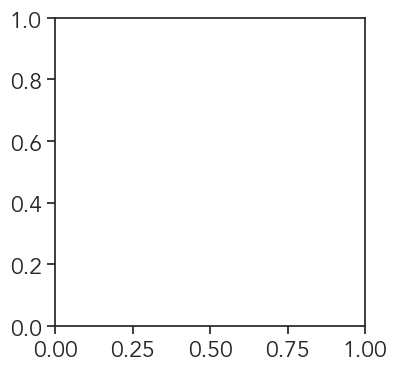

In [443]:
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,8*cms)
print(figsize)
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(data=dfS_SRF, x='Sobs', y='Spred', ax=ax, hue='DeltaS', map="PiYG", s=50, vmin=-1, vmax=1,
               edgecolor='black',
                linewidth=1,
               # color='lightgrey',
               )

'''
sns.scatterplot(data=dfS_DCM, x='Sobs', y='Spred', ax=ax,
                marker='s',
               edgecolor='black',
                linewidth=1,
                color='white',
               )
'''
ax.set(xscale="log", yscale="log", xlim=(6,1200), ylim=(6,1200), 
       xlabel='', 
       ylabel=''
      )

x = np.linspace(6,1200)
ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')

ax.legend().set_visible(False)

plt.show()
fig.savefig(fig_dir  + 'fig3_S.svg', facecolor='none', edgecolor='none')

In [450]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import TwoSlopeNorm

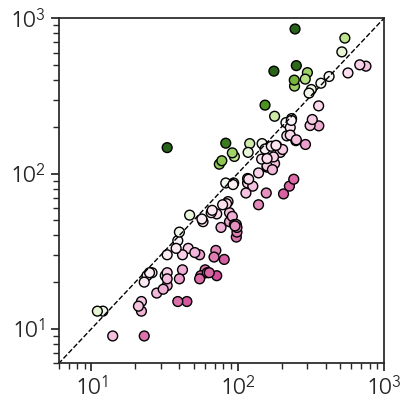

In [458]:
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)

# Create a colormap
cmap = plt.get_cmap("PiYG")

# Create a two-slope normalization centered around 0
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Use ax.scatter instead of seaborn
sc = ax.scatter(dfS_SRF['Sobs'], dfS_SRF['Spred'], c=dfS_SRF['DeltaS'], cmap=cmap, norm=norm, s=50, edgecolor='black', linewidth=1)

ax.set(xscale="log", yscale="log", xlim=(6,1000), ylim=(6,1000), 
       xlabel='', 
       ylabel=''
      )

x = np.linspace(6,1200)
#ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)
ax.plot([1, 1e4], [1, 1e4], color='black', lw=1, ls='--', alpha=1, zorder=1)

#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
#plt.gca().yaxis.set_ticks_position('right')


plt.show()
fig.savefig(fig_dir  + 'fig3_S.svg', facecolor='none', edgecolor='none')


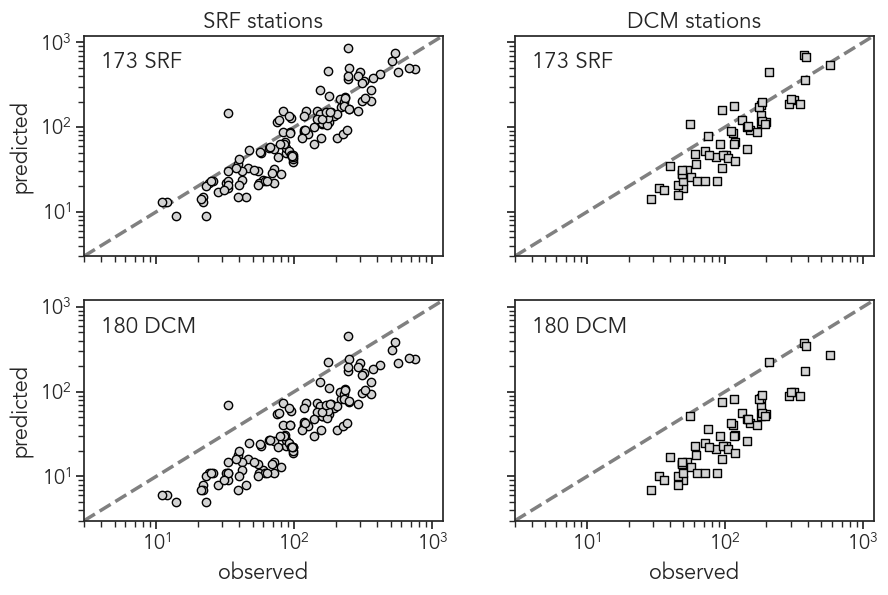

In [31]:
figsize4 = (2*golden*8*cms,2*8*cms)
fig, axs = plt.subplots(2,2, figsize=figsize4, sharex=True, sharey=True)
for ax in axs.flat:
    ax.set(xscale="log", yscale="log", xlim=(3,1200), ylim=(3,1200), 
       #xlabel='observed  ', 
       #ylabel='predicted  '
      )
    x = np.linspace(3,1200)
    ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)

sns.scatterplot(data=dfS.loc[SRFstations,:], x='Sobs', y='Spred', ax=axs[0,0],
               edgecolor='black',
                linewidth=1,
                color='lightgrey',
                #label='SRF'
               )
axs[0,0].set_ylabel('predicted')
#axs[0,0].text(150, 15, 'SRF stations', fontsize=14)
axs[0,0].text(4, 500, '173 SRF', fontsize=16)
axs[0,0].set_title('SRF stations', fontsize=16)

sns.scatterplot(data=dfS.loc[DCMstations,:], x='Sobs', y='Spred', ax=axs[0,1],
                marker='s',
               edgecolor='black',
                linewidth=1,
                color='lightgrey',
               )
#axs[0,1].text(150, 15, 'DCM stations', fontsize=14)
axs[0,1].text(4, 500, '173 SRF', fontsize=16)
axs[0,1].set_title('DCM stations', fontsize=16)

sns.scatterplot(data=dfS_180.loc[SRFstations,:], x='Sobs', y='Spred', ax=axs[1,0],
               edgecolor='black',
                linewidth=1,
                color='lightgrey',
               )
axs[1,0].set_ylabel('predicted')
axs[1,0].set_xlabel('observed')
#axs[1,0].text(150, 10, 'SRF stations', fontsize=14)
axs[1,0].text(4, 500, '180 DCM', fontsize=16)

sns.scatterplot(data=dfS_180.loc[DCMstations,:], x='Sobs', y='Spred', ax=axs[1,1],
                marker='s',
               edgecolor='black',
                linewidth=1,
                color='lightgrey',
               )
axs[1,1].set_xlabel('observed')
#axs[1,1].text(150, 10, 'DCM stations', fontsize=14)
axs[1,1].text(4, 500, '180 DCM', fontsize=16)


plt.show()

fig.savefig(fig_dir  + 'fig_ds/S_scatter_all.pdf', facecolor='none', edgecolor='none')


(10, 7.5)


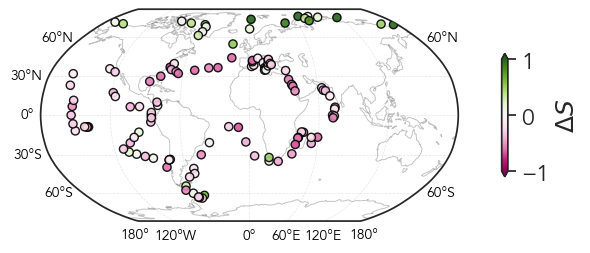

In [461]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=(7,4))
print(figsize_geo)
ax.set_global()
#ax.stock_img()

#ax.background_img(name='BM', resolution='low')
ax.coastlines(alpha=0.25,lw=0.65)

# change font size of the grid labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.2, linestyle='--', zorder=0,  xlabel_style={'size': 10, 'color': 'black'}, ylabel_style={'size': 10, 'color': 'black'})
# remove grid labels on top and right
gl.top_labels = False
gl.right_labels = False

column = "DeltaS_SRF"
cmap = "PiYG"
#cmap = cmocean.cm.balance
cbar = gdf.plot(column=column, cmap=cmap, transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=-1., vmax=1.,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=35,
                 legend_kwds={'shrink': 0.4, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'vertical', 
                      'extend':'both', "fmt": "{:1.0e}",
                      'label': r'$\Delta S$'
                     })

fig.savefig(fig_dir + 'fig3_DS_SRF.svg', dpi=300 , facecolor='none', edgecolor='none', bbox_inches='tight', transparent=True)

In [468]:
np.logspace(1, np.log10(600), 8)

array([ 10.        ,  17.94822921,  32.21389319,  57.81823389,
       103.77349145, 186.25504109, 334.29481697, 600.        ])

In [464]:
gdf[gdf['station']==43]

station  latitude  longitude depth_category  depth_nominal  month    SSD   
26       43    4.6599    73.4856            SUR              5      4  731.0  \

     temp_woa    sal_woa  no3_woa  ...  absolute_DS  text_color  lambda_SRF   
26  30.090109  34.421989   0.2505  ...     0.117647       black    1.403039  \

    alpha_SRF  beta_SRF  r_SRF lambda_DCM alpha_DCM  beta_DCM  r_DCM  
26   0.318429  0.721468    0.0        NaN       NaN       NaN    NaN  

[1 rows x 42 columns]

In [107]:
fit = linregress(x=gdf.loc[gdf['DeltaS_SRF']<=1., 'DeltaS_SRF'],
                y=gdf.loc[gdf['DeltaS_SRF']<=1., 'Evenness_SRF'])

In [108]:
fit.slope

-0.34474508902250556

In [98]:
len(gdf.loc[gdf['DeltaS_SRF']<=1.])

121

In [135]:
fit.rvalue

-0.6901332564008943

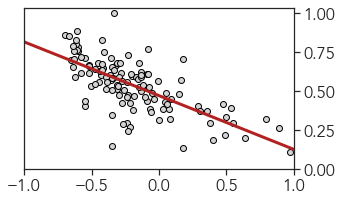

In [149]:
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,8*cms)
fig, ax = plt.subplots(figsize=figsize)

sns.scatterplot(data=gdf.loc[gdf['DeltaS_SRF']<=1.], 
                x='DeltaS_SRF', 
                y='Evenness_SRF', 
                ax=ax,
                edgecolor='black',
                linewidth=1,
                #hue ='TotAbundance_SRF',
                #hue_norm = clrs.LogNorm(),
                legend = False,
                #palette = sns.light_palette("grey", as_cmap=True)
                #palette = sns.color_palette("gray_r", as_cmap=True)
                color='lightgrey',
               )

#plt.colorbar(palette = sns.color_palette("gray_r", as_cmap=True), ax=ax)
ax.set(#xscale="log", yscale="log", 
    xlim=(-1, 1), 
    ylim=(-0.0,1.03), 
       xlabel='', 
       ylabel='',
    yticks = [0.0, 0.25, 0.5, 0.75, 1.]
      )

x_axis = np.linspace(-1, 1)
y_axis = fit.intercept+fit.slope*x_axis
ax.plot(x_axis, y_axis, lw=3, ls='-', color='firebrick')

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')


fig.tight_layout()
plt.show()
fig.savefig(fig_dir  + 'fig_ds/DeltaS_vs_Evenness.svg', facecolor='none', edgecolor='none')

In [22]:
fit.slope

-0.34474508902250556

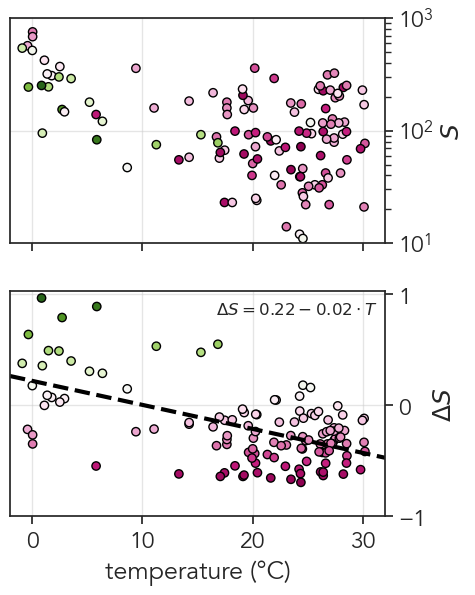

In [574]:
golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,16*cms)
fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

ax = axes[0]
sns.scatterplot(data=gdf.loc[gdf['DeltaS_SRF']<=1.], 
                x='temp_woa', 
                y='Richness_SRF', 
                ax=ax,
                edgecolor='black',
                linewidth=1,
                hue ='DeltaS_SRF',
                #hue_norm = clrs.LogNorm(),
                legend = False,
                palette = "PiYG",
                #palette = sns.light_palette("grey", as_cmap=True)
                #palette = sns.color_palette("gray_r", as_cmap=True)
                color='lightgrey',
               )

#plt.colorbar(palette = sns.color_palette("gray_r", as_cmap=True), ax=ax)
ax.set(#xscale="log", yscale="log", 
       xlim=(-2, 32), 
       ylim=(1e1,1e3), 
       xlabel='temperature (°C)', 
       ylabel=r'$S$',
       yscale = 'log'
    #yticks = [0.0, 0.25, 0.5, 0.75, 1.]
      )

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)

fit = linregress(x=gdf.loc[gdf['DeltaS_SRF']<=1., 'temp_woa'],
                y=gdf.loc[gdf['DeltaS_SRF']<=1., 'Richness_SRF'])

x_axis = np.linspace(-2, 32)
y_axis = fit.intercept+fit.slope*x_axis
label = r'$\Delta S = {:.2f} {:.2f} \cdot T$'.format(fit.intercept, fit.slope)
#ax.text(x=0.55, y=0.9, s=label, transform=ax.transAxes, fontsize=12)
#ax.text(x=0.55, y=0.8, s=r'$r^2 = {:.2f}$'.format(fit.rvalue**2), transform=ax.transAxes, fontsize=12)
#ax.plot(x_axis, y_axis, lw=3, ls='--', color='black', label=label)
#ax.legend(fontsize=12)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')

ax = axes[1]
sns.scatterplot(data=gdf.loc[gdf['DeltaS_SRF']<=1.], 
                x='temp_woa', 
                y='DeltaS_SRF', 
                ax=ax,
                edgecolor='black',
                linewidth=1,
                hue ='DeltaS_SRF',
                #hue_norm = clrs.LogNorm(),
                legend = False,
                palette = "PiYG",
                #palette = sns.light_palette("grey", as_cmap=True)
                #palette = sns.color_palette("gray_r", as_cmap=True)
                color='lightgrey',
               )

#plt.colorbar(palette = sns.color_palette("gray_r", as_cmap=True), ax=ax)
ax.set(#xscale="log", yscale="log", 
       xlim=(-2, 32), 
       ylim=(-1,1.03), 
       xlabel='temperature (°C)', 
       ylabel=r'$\Delta S$',
    #yticks = [0.0, 0.25, 0.5, 0.75, 1.]
      )

ax.grid(True, which='major', axis='both', alpha=0.5, zorder=0)

fit = linregress(x=gdf.loc[gdf['DeltaS_SRF']<=1., 'temp_woa'],
                y=gdf.loc[gdf['DeltaS_SRF']<=1., 'DeltaS_SRF'])

x_axis = np.linspace(-2, 32)
y_axis = fit.intercept+fit.slope*x_axis
label = r'$\Delta S = {:.2f} {:.2f} \cdot T$'.format(fit.intercept, fit.slope)
ax.text(x=0.55, y=0.9, s=label, transform=ax.transAxes, fontsize=12)
#ax.text(x=0.55, y=0.8, s=r'$r^2 = {:.2f}$'.format(fit.rvalue**2), transform=ax.transAxes, fontsize=12)
ax.plot(x_axis, y_axis, lw=3, ls='--', color='black', label=label)
#ax.legend(fontsize=12)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')

fig.tight_layout()
plt.show()
fig.savefig(fig_dir  + 'figSMrichnessT.png', facecolor='none', edgecolor='none')

In [39]:
gdf.columns

Index(['station', 'latitude', 'longitude', 'depth_category', 'depth_nominal',
       'month', 'SSD', 'temp_woa', 'sal_woa', 'no3_woa', 'po4_woa',
       'sioh4_woa', 'dco', 'dcu', 'dfe', 'dzn', 'geometry', 'station_SRF',
       'TotAbundance_SRF', 'Richness_SRF', 'Shannon_SRF', 'Evenness_SRF',
       'station_DCM', 'TotAbundance_DCM', 'Richness_DCM', 'Shannon_DCM',
       'Evenness_DCM', 'region', 'DeltaS_SRF', 'DeltaS_DCM',
       'absolute_latitute'],
      dtype='object')

In [87]:
gdf['absolute_latitude'] = np.abs(gdf['latitude'])
gdf['absolute_DS'] = np.abs(gdf['DeltaS_SRF'])

In [88]:
import re

In [490]:
gdf

station  latitude  longitude depth_category  depth_nominal  month    SSD   
0          7   37.0434     1.9493            SUR              9      9  727.0  \
1          8   38.0050     3.9899            SUR              9      9  717.0   
2         10   40.6541     2.8407            SUR              9      9  711.0   
3         11   41.6645     2.7983            SUR              9     10    NaN   
4         12   43.3482     7.9010            SUR              5     10  675.0   
..       ...       ...        ...            ...            ...    ...    ...   
129      205   72.4693   -71.8920            SUR              5     10  584.5   
130      206   70.9618   -53.6030            SUR              5     10  564.5   
131      208   69.1136   -51.5086            SUR              5     10  508.0   
132      209   64.7127   -53.0106            SUR              5     10  531.5   
133      210   61.5442   -55.9865            SUR              5     10  535.0   

      temp_woa    sal_woa   no3_woa  ...  text_color  lambda_SRF  alpha_SRF   
0    25.320400  37.243389  0.654349  ...       black    1.328576  -0.463369  \
1    25.628609  37.451500  0.212858  ...       black    1.366194   0.020669   
2    24.797300  37.925713  0.072777  ...       black    1.285189  -0.500000   
3    21.630198  37.960928  0.007061  ...       black    1.859758   0.314928   
4    20.361670  38.178169  0.006583  ...       black    1.421328   1.946502   
..         ...        ...       ...  ...         ...         ...        ...   
129  -0.892610  31.219290  1.793274  ...       black    1.478733  -0.180625   
130   2.437630  32.896900  1.785118  ...       black    1.494958   0.665636   
131   2.938600  33.131413  1.630793  ...       black    1.389471   0.011506   
132   2.517510  32.442013  3.216127  ...       black    1.482517   0.307441   
133   5.203010  33.989799  3.419286  ...       black    1.394804  -0.184946   

     beta_SRF     r_SRF  lambda_DCM alpha_DCM  beta_DCM     r_DCM   
0   -0.134793  0.000000    1.406372 -0.196746  0.209626  0.000000  \
1    0.386863  0.000000    1.103913  0.030260  0.134172  0.011315   
2   -0.214811  0.001499    1.952869  0.445389  1.398258  0.000000   
3    1.174687  0.000000         NaN       NaN       NaN       NaN   
4    2.367830  0.000000    1.282857 -0.500000 -0.217143  0.000000   
..        ...       ...         ...       ...       ...       ...   
129  0.298108  0.000000         NaN       NaN       NaN       NaN   
130  1.160594  0.000000         NaN       NaN       NaN       NaN   
131  0.400977  0.000000         NaN       NaN       NaN       NaN   
132  0.789959  0.000000         NaN       NaN       NaN       NaN   
133  0.209857  0.000000         NaN       NaN       NaN       NaN   

     lambda_SRF_ML  
0         1.614192  
1         1.605167  
2         1.909813  
3         1.971472  
4         1.514028  
..             ...  
129       1.631053  
130       1.475598  
131       1.499320  
132       1.521328  
133       1.540261  

[134 rows x 43 columns]

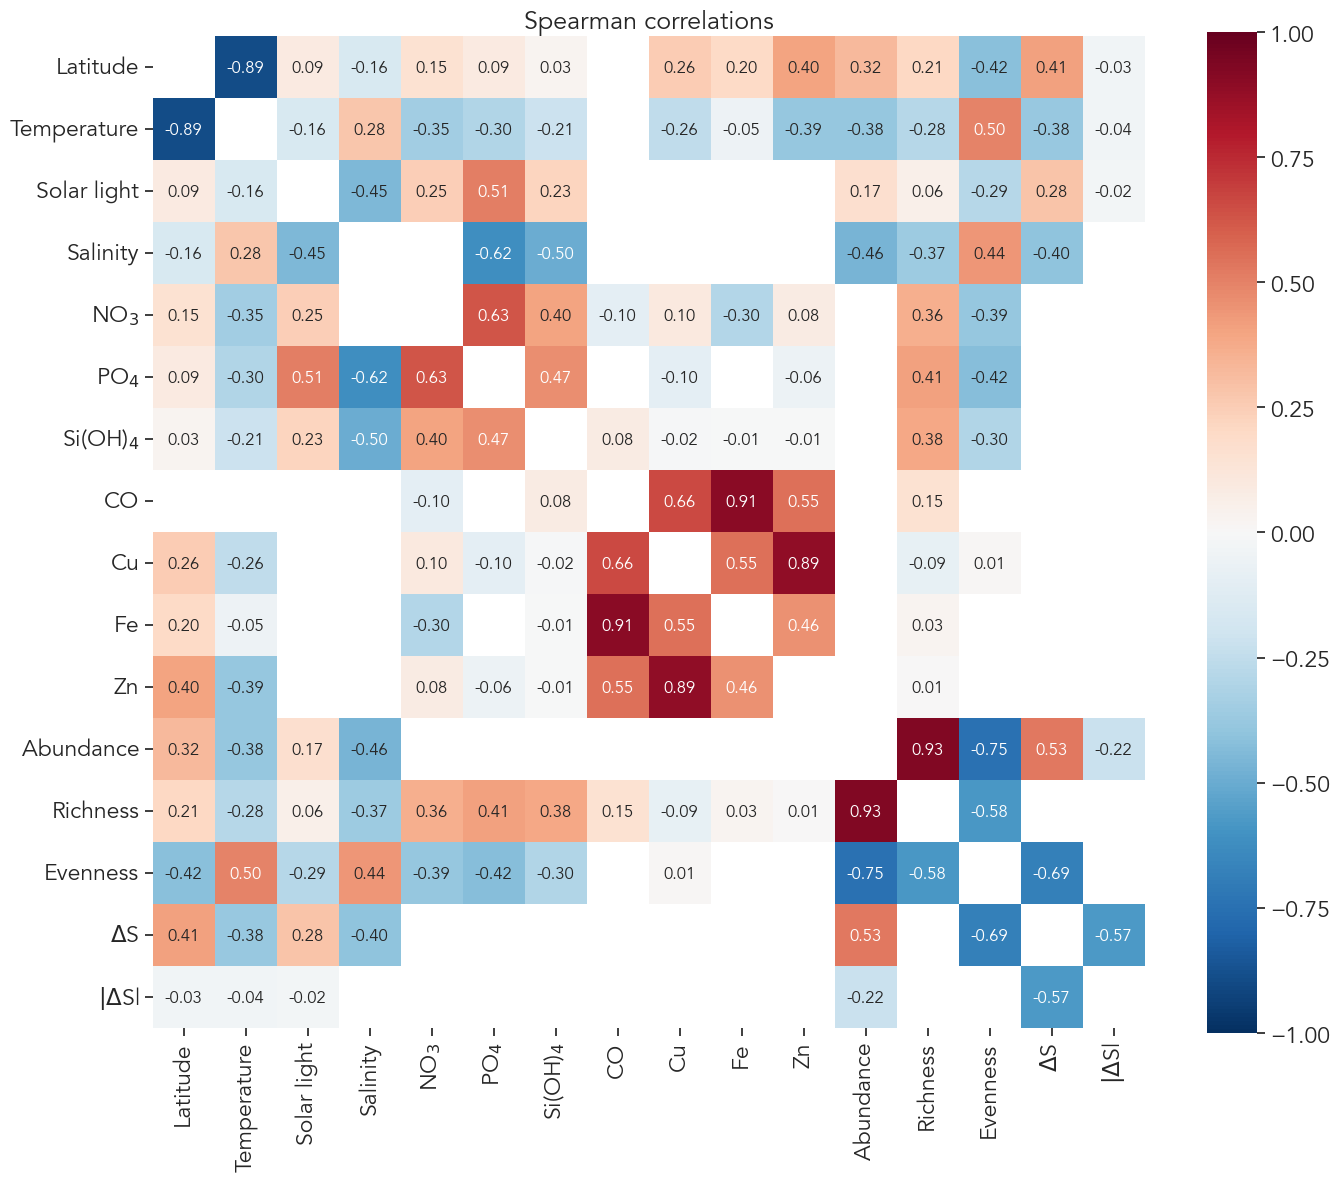

In [489]:
# select only columns of gdf that contains numbers as values (i.e. not strings)
columns_numbers = [col for col in gdf.columns if gdf[col].dtype in [np.float64, np.int64]]
# remove columns from columns_numbers that contain the string "DCM" inside the name using regex
columns_numbers = [col for col in columns_numbers if not re.search('DCM', col)]
columns_numbers = ['absolute_latitude', 'temp_woa', 'SSD', 'sal_woa', 'no3_woa', 'po4_woa', 'sioh4_woa',
                   'dco', 'dcu', 'dfe', 'dzn',
                   'TotAbundance_SRF', 'Richness_SRF', 'Evenness_SRF','DeltaS_SRF', 'absolute_DS']
# compute correlation matrix and plot it
corr = gdf.loc[gdf['DeltaS_SRF']<=1.,columns_numbers].corr('spearman')
dictionary = {'Richness_SRF':'Richness', 'absolute_latitude':'Latitude', 'longitude':'Longitude', 
              'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'temp_woa':'Temperature', 'DeltaS_SRF':r'$\Delta$S',
              'sal_woa': 'Salinity', 'no3_woa': 'NO$_3$', 'po4_woa': 'PO$_4$', 'sioh4_woa': 'Si(OH)$_4$',
              'dco': 'CO', 'dcu': 'Cu', 'dfe': 'Fe', 'dzn': 'Zn', 'SSD': 'Solar light', 'absolute_DS': r'$|\Delta$S|'
              }
corr.rename(columns=dictionary,
           index=dictionary,
            inplace=True
           )
pvalues = calculate_pvalues(gdf[columns_numbers])
mask = np.ones_like(corr)-np.diag(np.ones(len(corr)))
mask = (mask)*(pvalues<1e-2).values
fig, ax = plt.subplots(figsize=(16,13))
sns.heatmap(corr, annot=True, fmt = ".2f", mask = 1-mask, square=True, 
            annot_kws={"size": 12}, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('Spearman correlations')

fig.savefig(fig_dir + 'correlation_matrix.png', dpi=300 , facecolor='none', edgecolor='none', bbox_inches='tight', transparent=True)

In [493]:
# loc where alpha_SRF is not nan
gdf.loc[gdf['alpha_SRF'].notna() , ['station', 'latitude', 'longitude', 'alpha_SRF', 'beta_SRF', 'r_SRF']].set_index('station').head(123)

latitude  longitude  alpha_SRF  beta_SRF     r_SRF
station                                                    
7         37.0434     1.9493  -0.463369 -0.134793  0.000000
8         38.0050     3.9899   0.020669  0.386863  0.000000
10        40.6541     2.8407  -0.500000 -0.214811  0.001499
11        41.6645     2.7983   0.314928  1.174687  0.000000
12        43.3482     7.9010   1.946502  2.367830  0.000000
...           ...        ...        ...       ...       ...
205       72.4693   -71.8920  -0.180625  0.298108  0.000000
206       70.9618   -53.6030   0.665636  1.160594  0.000000
208       69.1136   -51.5086   0.011506  0.400977  0.000000
209       64.7127   -53.0106   0.307441  0.789959  0.000000
210       61.5442   -55.9865  -0.184946  0.209857  0.000000

[123 rows x 5 columns]

In [62]:
column_corr = ['temp_woa',  'TotAbundance_SRF','Richness_SRF',  'Evenness_SRF','DeltaS_SRF']
Corr_p= gdf.loc[gdf['DeltaS_SRF']<=10.,column_corr].corr('pearson')
Corr= gdf.loc[gdf['DeltaS_SRF']  <=10.,column_corr].corr('spearman')
pvalues = calculate_pvalues(gdf.loc[gdf['DeltaS_SRF']<=1.,column_corr]) 
Corr.head()

temp_woa  TotAbundance_SRF  Richness_SRF  Evenness_SRF   
temp_woa          1.000000         -0.419722     -0.289300      0.528906  \
TotAbundance_SRF -0.419722          1.000000      0.909180     -0.761183   
Richness_SRF     -0.289300          0.909180      1.000000     -0.562849   
Evenness_SRF      0.528906         -0.761183     -0.562849      1.000000   
DeltaS_SRF       -0.419877          0.554271      0.209406     -0.708125   

                  DeltaS_SRF  
temp_woa           -0.419877  
TotAbundance_SRF    0.554271  
Richness_SRF        0.209406  
Evenness_SRF       -0.708125  
DeltaS_SRF          1.000000

In [55]:
pvalues

temp_woa TotAbundance_SRF Richness_SRF Evenness_SRF   
temp_woa              0.0              0.0          0.0          0.0  \
TotAbundance_SRF      0.0              0.0          0.0          0.0   
Richness_SRF          0.0              0.0          0.0          0.0   
Evenness_SRF          0.0              0.0          0.0          0.0   
DeltaS_SRF            0.0         0.000024     0.038758          0.0   

                 DeltaS_SRF  
temp_woa                0.0  
TotAbundance_SRF   0.000024  
Richness_SRF       0.038758  
Evenness_SRF            0.0  
DeltaS_SRF              0.0

In [56]:
# Correlation plot that is present on the paper

In [57]:
Corr.rename(columns={'Richness_SRF':'Richness', 'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'temp_woa':'Temperature', 'DeltaS_SRF':r'$\Delta$S'},
           index={'Richness_SRF':'Richness', 'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'temp_woa':'Temperature', 'DeltaS_SRF':r'$\Delta$S'},
            inplace=True
           )

In [58]:
sns.set(font='Avenir', font_scale=1.5, style='ticks')

In [59]:
pvalues<1e-3

temp_woa  TotAbundance_SRF  Richness_SRF  Evenness_SRF   
temp_woa              True              True          True          True  \
TotAbundance_SRF      True              True          True          True   
Richness_SRF          True              True          True          True   
Evenness_SRF          True              True          True          True   
DeltaS_SRF            True              True         False          True   

                  DeltaS_SRF  
temp_woa                True  
TotAbundance_SRF        True  
Richness_SRF           False  
Evenness_SRF            True  
DeltaS_SRF              True

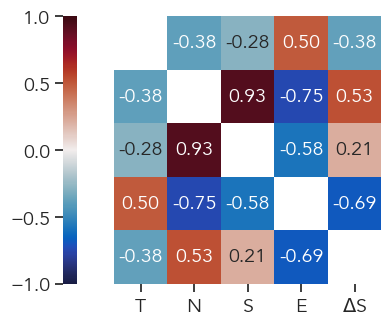

In [60]:
#mask = np.tril(np.ones_like(Corr.corr()))-np.diag(np.ones(5))
mask = np.ones_like(Corr.corr())-np.diag(np.ones(5))
#mask = (mask)*(pvalues<1e-2).values

fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

sns.heatmap(data=Corr, ax=ax, 
            mask=1-mask,
            #annot=pvalues, fmt="1.1e",
            annot=True, fmt = ".2f",
           # mask = (pvalues<1e-3)*1.,
            annot_kws={"size": 14},
            vmax=1, vmin=-1,
            #ticklabels=['','','','',''],
            xticklabels=['T','N','S','E',r'$\Delta$S'],
            yticklabels=False,#['T','N','S','E',r'$\Delta$S'],
            square=True, cmap=cmocean.cm.balance,
            cbar_kws={ 'orientation': 'vertical', 'shrink': 1.,'pad':.08, 
                      'location':"left"
                     },
            #sns.color_palette("coolwarm", as_cmap=True)
           )

#fig.tight_layout()
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

fig.savefig(fig_dir + 'correlations.svg', dpi=300, facecolor='none', edgecolor='none')
fig.savefig(fig_dir + 'correlations.png', dpi=300)
fig.savefig(fig_dir + 'correlations.pdf', dpi=300)

In [47]:
# correlation plot with also lambda SRF

In [49]:
column_corr = ['Richness_SRF', 'TotAbundance_SRF', 'Evenness_SRF', 'DeltaS_SRF', 'temp_woa', 'lambda_SRF']
Corr_p= gdf.loc[gdf['DeltaS_SRF']<=1.,column_corr].corr('pearson')
Corr= gdf.loc[gdf['DeltaS_SRF']<=1.,column_corr].corr('spearman')
pvalues = calculate_pvalues(gdf.loc[gdf['DeltaS_SRF']<=1.,column_corr]) 
Corr.head(6)

Richness_SRF  TotAbundance_SRF  Evenness_SRF  DeltaS_SRF  \
Richness_SRF          1.000000          0.926025     -0.578644    0.211843   
TotAbundance_SRF      0.926025          1.000000     -0.748936    0.530814   
Evenness_SRF         -0.578644         -0.748936      1.000000   -0.687152   
DeltaS_SRF            0.211843          0.530814     -0.687152    1.000000   
temp_woa             -0.282449         -0.382857      0.495247   -0.381290   
lambda_SRF           -0.018143         -0.065907     -0.239330   -0.136711   

                  temp_woa  lambda_SRF  
Richness_SRF     -0.282449   -0.018143  
TotAbundance_SRF -0.382857   -0.065907  
Evenness_SRF      0.495247   -0.239330  
DeltaS_SRF       -0.381290   -0.136711  
temp_woa          1.000000   -0.183952  
lambda_SRF       -0.183952    1.000000

In [50]:
pvalues

Richness_SRF TotAbundance_SRF Evenness_SRF DeltaS_SRF  \
Richness_SRF              0.0              0.0          0.0   0.042375   
TotAbundance_SRF          0.0              0.0          0.0   0.000027   
Evenness_SRF              0.0              0.0          0.0        0.0   
DeltaS_SRF           0.042375         0.000027          0.0        0.0   
temp_woa                  0.0              0.0          0.0        0.0   
lambda_SRF           0.573452         0.305272     0.296347   0.212141   

                  temp_woa lambda_SRF  
Richness_SRF           0.0   0.573452  
TotAbundance_SRF       0.0   0.305272  
Evenness_SRF           0.0   0.296347  
DeltaS_SRF             0.0   0.212141  
temp_woa               0.0   0.383818  
lambda_SRF        0.383818        0.0

In [ ]:
Corr.rename(columns={'Richness_SRF':'Richness', 'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'DeltaS_SRF':r'$\Delta$S', 'temp_woa':'Temperature'},
           index={'Richness_SRF':'Richness', 'TotAbundance_SRF':'Abundance', 'Evenness_SRF':'Evenness', 'DeltaS_SRF':r'$\Delta$S', 'temp_woa':'Temperature'},
            inplace=True
           )

### Clustering analysis

In [29]:
data = gdf.loc[gdf['DeltaS_SRF']<=1.]

In [30]:
kmeans = KMeans(n_clusters=3).fit(data.loc[:,['DeltaS_SRF','temp_woa',
                                              'no3_woa', 
                                              #'longitude',
                                        #     'sal_woa', 'no3_woa', 'po4_woa',
                                       #'sioh4_woa', 'dco', 'dcu', 'dfe', 'dzn'
                                             ]])
centroids = kmeans.cluster_centers_
labels = kmeans.labels_.astype(int)

<AxesSubplot:xlabel='$\\Delta S$', ylabel='Temperature'>

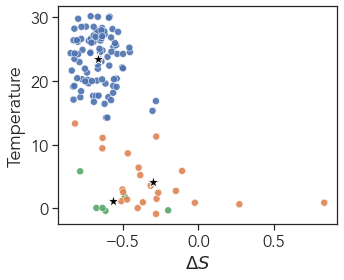

In [31]:
fig, ax = plt.subplots(figsize=(5,4))
kmeans.labels_.astype(float)
colors = [sns.color_palette()[i] for i in labels]

ax.set_xlabel(r'$\Delta S$')
ax.set_ylabel('Temperature')

sns.scatterplot(data=data,
                x='DeltaS_SRF',
                y='temp_woa', 
                c = colors, 
                s=50, 
                alpha=0.9, 
                ax=ax)

sns.scatterplot(x=centroids[:, 0], 
                y=centroids[:, 1], 
                color='black', 
                marker='*',
                s=150, ax=ax)

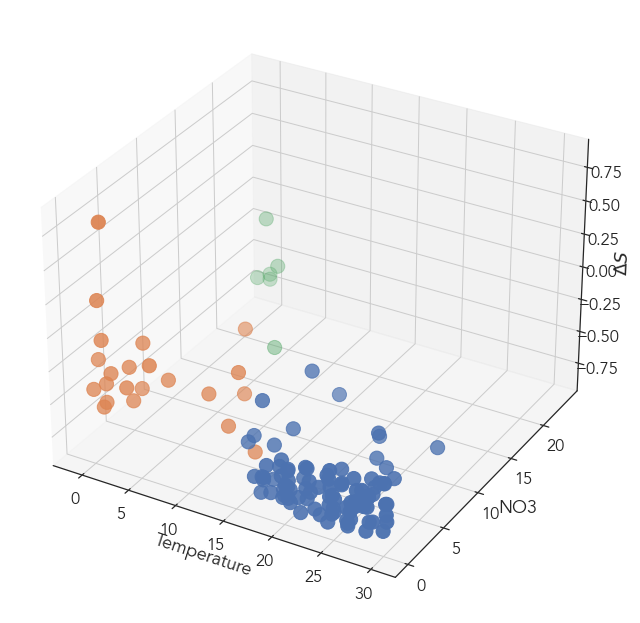

In [32]:
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111, projection='3d', )

ax.set_xlabel('Temperature')
ax.set_ylabel('NO3')
ax.set_zlabel(r'$\Delta S$')

ax.scatter(
        xs=data['temp_woa'],
        ys=data['no3_woa'],
        zs=data['DeltaS_SRF'],
        c = colors,
        s = 200
          )

#ax.view_init(10, -15)
fig.tight_layout()

### Testing the null-hypothesis

In [33]:
gdf['k_SRF'] = gdf['TotAbundance_SRF']/gdf['Richness_SRF']

<AxesSubplot:xlabel='k_SRF', ylabel='Count'>

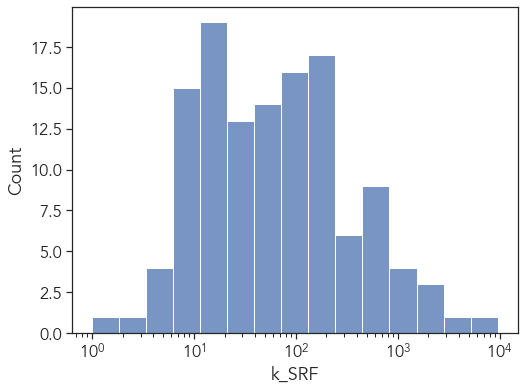

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(data=gdf,
    x= 'k_SRF',log_scale=True, bins=15,
    ax=ax)

## Insight on the total

In [35]:
corr_ab = Abundances.corr()

In [36]:
fig, ax = plt.subplots(figsize=figsize_geo, constrained_layout=True)

sns.heatmap(data=corr_ab, ax=ax, 
           # mask=mask,
            annot=True,  fmt=".2f", annot_kws={"size": 20},
            vmax=1, vmin=-1,
            square=True, cmap=cmocean.cm.balance
            #sns.color_palette("coolwarm", as_cmap=True)
           )

<AxesSubplot:>

Error in callback <function flush_figures at 0x7fcf99124ee0> (for post_execute):



KeyboardInterrupt



In [ ]:
Occ = ((Abundances>0)*1)

In [ ]:
overlap = np.zeros((len(Occ.columns), len(Occ.columns)))
for i in range(len(Occ.columns)):
    for j in range(len(Occ.columns)):
        if i != j:
            overlap[i,j] = np.dot(Occ.iloc[:,i],Occ.iloc[:,j])

In [ ]:
np.log10(overlap+1)

In [ ]:
fig, ax = plt.subplots(figsize=figsize_geo, constrained_layout=True)

sns.heatmap(data=np.log10(overlap+1), ax=ax) 

In [ ]:
fig, ax = plt.subplots(figsize=figsize_geo, constrained_layout=True)

sns.heatmap(data=overlap, ax=ax) 

In [ ]:
pd

# Fits

In [376]:
directory = '../data/'
fitBruno = pd.read_csv(directory + 'fit_completi.csv', index_col=0)

In [384]:
alpha_dict.keys()

dict_keys([158, 188, 194, 168, 206, 191, 180, 196, 173, 178, 189, 209, 193, 208, 155, 205, 163, 210, 175, 201, 72, 30, 25, 102, 23, 18, 68, 66, 65, 34, 82, 7, 84, 76, 31, 33, 42, 70, 38, 32, 98, 11, 20, 22, 24, 26, 39, 111, 122, 109, 123, 124, 125, 106, 10, 41, 110, 126, 127, 67, 128, 129, 12, 130, 131, 64, 132, 133, 135, 137, 138, 140, 144, 145, 14, 17, 19, 21, 52, 43, 46, 51, 53, 54, 57, 58, 62, 71, 80, 81, 83, 85, 86, 100, 87, 88, 89, 8, 90, 91, 92, 93, 94, 95, 96, 97, 99, 36, 136, 139, 141, 142, 143, 146, 147, 148, 149, 45, 150, 151, 152, 47, 49, 78])

In [389]:
fitBruno = fitBruno.rename(columns={'vec_estimated_k':'beta', 'vec_estimated_l':'alpha', 'vec_estimated_r':'r'})
fitBruno.reset_index(inplace=True)
fitBruno['station_number'] = fitBruno['station'].apply(lambda x: int(x.split('_')[0]))
fitBruno['lambda'] = 1 - fitBruno.loc[:,'alpha'] + fitBruno.loc[:,'beta']
# alpha_ML from the alpha_dict dictionary usign the station name as key
fitBruno['alpha_ML'] = fitBruno['station_number'].apply(lambda x: alpha_dict[x] if x in alpha_dict.keys() else np.nan)

In [390]:
fitBruno.head()

index  station      beta     alpha    r  vec_n  vec_x_max   
0      0  175_SRF  0.446619 -0.022956  0.0    247    2324400  \
1      1  180_DCM  0.218844 -0.242561  0.0    372    1140069   
2      2  188_DCM  0.517954  0.028993  0.0    386    1000952   
3      3  188_SRF  0.529419  0.018229  0.0    516     716203   
4      4  205_SRF  0.298108 -0.180625  0.0    541     600574   

   vec_ksmod_pvalue  check  mark    lambda  station_number  alpha_ML  
0               0.0  False     1  1.469575             175  1.564120  
1               0.0  False     1  1.461405             180  1.560167  
2               0.0  False     1  1.488961             188  1.575859  
3               0.0  False     1  1.511190             188  1.575859  
4               0.0  False     1  1.478733             205  1.631053

In [379]:
fitBruno = fitBruno.set_index('station')#.T
fitBruno.head()

beta     alpha    r  vec_n  vec_x_max  vec_ksmod_pvalue  check   
station                                                                       
175_SRF  0.446619 -0.022956  0.0    247    2324400               0.0  False  \
180_DCM  0.218844 -0.242561  0.0    372    1140069               0.0  False   
188_DCM  0.517954  0.028993  0.0    386    1000952               0.0  False   
188_SRF  0.529419  0.018229  0.0    516     716203               0.0  False   
205_SRF  0.298108 -0.180625  0.0    541     600574               0.0  False   

         mark    lambda  
station                  
175_SRF     1  1.469575  
180_DCM     1  1.461405  
188_DCM     1  1.488961  
188_SRF     1  1.511190  
205_SRF     1  1.478733

In [380]:
for depth in Depths:
    gdf['lambda_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fitBruno.loc[x,'lambda'] if x in fitBruno.index else None)
    gdf['alpha_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fitBruno.loc[x,'alpha'] if x in fitBruno.index else None)
    gdf['beta_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fitBruno.loc[x,'beta'] if x in fitBruno.index else None)
    gdf['r_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: fitBruno.loc[x,'r'] if x in fitBruno.index else None)

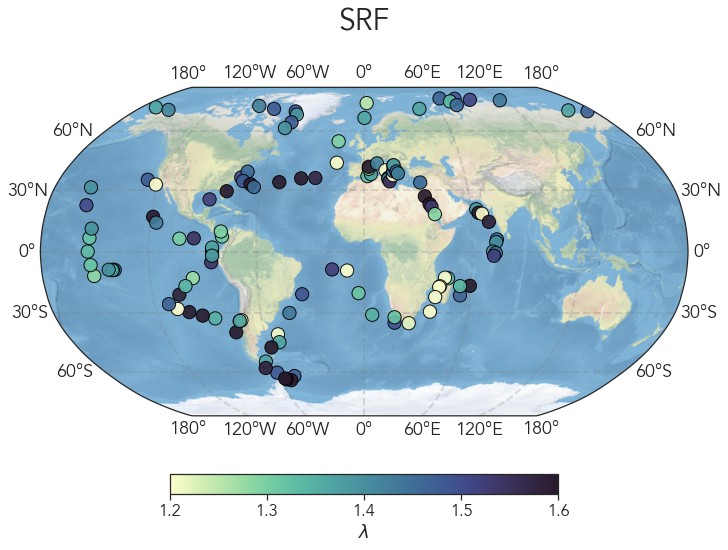

In [269]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, figsize=figsize_geo, constrained_layout=True)
ax.set_global()
ax.stock_img()
fig.suptitle('SRF', size=30)
#ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.25, linestyle='--')

column = "lambda_SRF"
cbar = gdf.plot(column=column, cmap=cmocean.cm.deep,#cmocean.cm.deep, 
                transform = ccrs.Geodetic(), ax=ax, zorder=10, vmin=1.2, vmax=1.6,
                #norm=clrs.Norm(vmin=gdf[column].min(), vmax=gdf[column].max()),
         legend=True, alpha=0.9, lw=1, edgecolors='black', s=175,
                 legend_kwds={'shrink': 0.6, 'pad':0.08, #'ticks':ticks,# 'set_yticklabels':ticks_labels,
                      'orientation': 'horizontal', 
                      #'extend':'max',
                      "fmt": "{:1.0e}",
                      'label': r'$\lambda$'
                     })

fig.savefig(fig_dir + column + '.pdf')

In [289]:
DeltaS = np.concatenate(gdf.DeltaS_SRF.values, gdf.DeltaS_DCM.values)
DeltaS

TypeError: only integer scalar arrays can be converted to a scalar index

<AxesSubplot:xlabel='DeltaS_SRF', ylabel='lambda_SRF'>

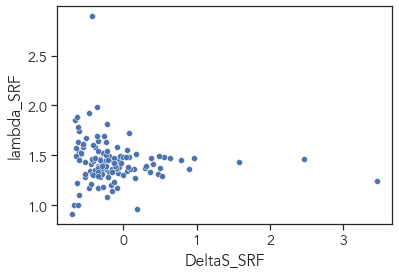

In [45]:
fig, ax = plt.subplots()
sns.scatterplot(data=gdf, x="DeltaS_SRF", y="lambda_SRF")

In [51]:
Abundances.columns[Abundances.columns=='019_SRF']

Index(['019_SRF'], dtype='object')

In [290]:
len(lambdas)

NameError: name 'lambdas' is not defined

In [391]:
df_lambdas = pd.DataFrame(lambdas, index=Abundances.columns)

NameError: name 'lambdas' is not defined

In [52]:
for depth in Depths:
    gdf['Evenness_{}'.format(depth)] = gdf['Shannon_{}'.format(depth)]/np.log(gdf['Richness_{}'.format(depth)])

In [53]:
gdf['lambda'] = lambdas

NameError: name 'lambdas' is not defined

In [101]:
order = ['equatorial', 'tropical', 'polar']
palette = {
    'equatorial': '#fc8d62',
    'tropical': '#66c2a5',
    'polar': '#8da0cb'
}

In [291]:
gdf.columns

Index(['station', 'latitude', 'longitude', 'depth_category', 'depth_nominal',
       'month', 'SSD', 'temp_woa', 'sal_woa', 'no3_woa', 'po4_woa',
       'sioh4_woa', 'dco', 'dcu', 'dfe', 'dzn', 'geometry', 'station_SRF',
       'TotAbundance_SRF', 'Richness_SRF', 'Shannon_SRF', 'Evenness_SRF',
       'station_DCM', 'TotAbundance_DCM', 'Richness_DCM', 'Shannon_DCM',
       'Evenness_DCM', 'region', 'DeltaS_SRF', 'DeltaS_DCM', 'lambda_SRF',
       'alpha_SRF', 'beta_SRF', 'r_SRF', 'lambda_DCM', 'alpha_DCM', 'beta_DCM',
       'r_DCM'],
      dtype='object')

In [107]:
gdf

station  latitude  longitude depth_category  depth_nominal  month    SSD  \
0          7   37.0434     1.9493            SUR              9      9  727.0   
1          8   38.0050     3.9899            SUR              9      9  717.0   
2         10   40.6541     2.8407            SUR              9      9  711.0   
3         11   41.6645     2.7983            SUR              9     10    NaN   
4         12   43.3482     7.9010            SUR              5     10  675.0   
..       ...       ...        ...            ...            ...    ...    ...   
129      205   72.4693   -71.8920            SUR              5     10  584.5   
130      206   70.9618   -53.6030            SUR              5     10  564.5   
131      208   69.1136   -51.5086            SUR              5     10  508.0   
132      209   64.7127   -53.0106            SUR              5     10  531.5   
133      210   61.5442   -55.9865            SUR              5     10  535.0   

      temp_woa    sal_woa   no3_woa  ...  alpha_SRF  beta_SRF     r_SRF  \
0    25.320400  37.243389  0.654349  ...  -0.463369 -0.134793  0.000000   
1    25.628609  37.451500  0.212858  ...   0.020669  0.386863  0.000000   
2    24.797300  37.925713  0.072777  ...  -0.500000 -0.214811  0.001499   
3    21.630198  37.960928  0.007061  ...   0.314928  1.174687  0.000000   
4    20.361670  38.178169  0.006583  ...   1.946502  2.367830  0.000000   
..         ...        ...       ...  ...        ...       ...       ...   
129  -0.892610  31.219290  1.793274  ...  -0.180625  0.298108  0.000000   
130   2.437630  32.896900  1.785118  ...   0.665636  1.160594  0.000000   
131   2.938600  33.131413  1.630793  ...   0.011506  0.400977  0.000000   
132   2.517510  32.442013  3.216127  ...   0.307441  0.789959  0.000000   
133   5.203010  33.989799  3.419286  ...  -0.184946  0.209857  0.000000   

     lambda_DCM  alpha_DCM  beta_DCM     r_DCM DeltaS_SRF  DeltaS_DCM  \
0      1.406372  -0.196746  0.209626  0.000000  -0.074468   -0.260870   
1      1.103913   0.030260  0.134172  0.011315  -0.090909   -0.428571   
2      1.952869   0.445389  1.398258  0.000000  -0.318182   -0.652174   
3           NaN        NaN       NaN       NaN  -0.654321         NaN   
4      1.282857  -0.500000 -0.217143  0.000000  -0.083333   -0.540000   
..          ...        ...       ...       ...        ...         ...   
129         NaN        NaN       NaN       NaN   0.378928         NaN   
130         NaN        NaN       NaN       NaN   0.490000         NaN   
131         NaN        NaN       NaN       NaN   0.061224         NaN   
132         NaN        NaN       NaN       NaN   0.029650         NaN   
133         NaN        NaN       NaN       NaN   0.307263         NaN   

       region  
0    tropical  
1    tropical  
2    tropical  
3    tropical  
4    tropical  
..        ...  
129     polar  
130     polar  
131     polar  
132     polar  
133     polar  

[134 rows x 38 columns]

In [293]:
fig_dir+column

'/Volumes/GoogleDrive/Il mio Drive/oldmac/tara/downscaling/fig/lambda_SRF'

NameError: name 'order' is not defined

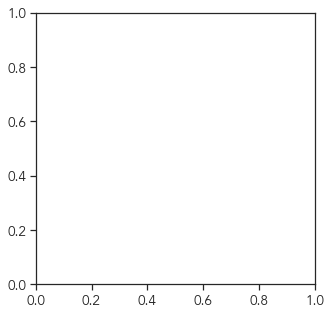

In [294]:
custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(font="Avenir", font_scale=1.25, style="ticks", rc=custom_params)

column = "lambda_SRF"
fig, ax = plt.subplots(figsize=(5,5))

sns.boxplot(x="region", y="lambda_SRF", data=gdf, order = order, ax=ax, palette=palette)
sns.swarmplot(x="region", y="lambda_SRF", data=gdf, order = order, color=".25", ax=ax)

ax.set_xlabel('')
ax.set_ylabel(r'$\lambda$')#,fontsize=12)
#ax.set_ylim(1.,2.)
#ax.set_title('{meta} - {fit} fit'.format(meta=metas_name, fit=fit_method))#, size=22)

plt.show()
#fig_name = '/beta_vs_latitudeclass_{dataset}_{meta}_{fit}'.format(dataset=dataset_name, meta=metas_name, fit=fit_method)
fig.tight_layout()
fig.savefig(fig_dir + column + '_box.pdf')

# Mantel Test

In [298]:
!pip install skbio.math

ERROR: Could not find a version that satisfies the requirement skbio.math (from versions: none)
ERROR: No matching distribution found for skbio.math


In [295]:
from skbio.math.stats import distance

ModuleNotFoundError: No module named 'skbio.math'

In [296]:
gdf

station  latitude  longitude depth_category  depth_nominal  month    SSD  \
0          7   37.0434     1.9493            SUR              9      9  727.0   
1          8   38.0050     3.9899            SUR              9      9  717.0   
2         10   40.6541     2.8407            SUR              9      9  711.0   
3         11   41.6645     2.7983            SUR              9     10    NaN   
4         12   43.3482     7.9010            SUR              5     10  675.0   
..       ...       ...        ...            ...            ...    ...    ...   
129      205   72.4693   -71.8920            SUR              5     10  584.5   
130      206   70.9618   -53.6030            SUR              5     10  564.5   
131      208   69.1136   -51.5086            SUR              5     10  508.0   
132      209   64.7127   -53.0106            SUR              5     10  531.5   
133      210   61.5442   -55.9865            SUR              5     10  535.0   

      temp_woa    sal_woa   no3_woa  ...  DeltaS_SRF  DeltaS_DCM  lambda_SRF  \
0    25.320400  37.243389  0.654349  ...   -0.074468   -0.260870    1.328576   
1    25.628609  37.451500  0.212858  ...   -0.090909   -0.428571    1.366194   
2    24.797300  37.925713  0.072777  ...   -0.318182   -0.652174    1.285189   
3    21.630198  37.960928  0.007061  ...   -0.654321         NaN    1.859758   
4    20.361670  38.178169  0.006583  ...   -0.083333   -0.540000    1.421328   
..         ...        ...       ...  ...         ...         ...         ...   
129  -0.892610  31.219290  1.793274  ...    0.378928         NaN    1.478733   
130   2.437630  32.896900  1.785118  ...    0.490000         NaN    1.494958   
131   2.938600  33.131413  1.630793  ...    0.061224         NaN    1.389471   
132   2.517510  32.442013  3.216127  ...    0.029650         NaN    1.482517   
133   5.203010  33.989799  3.419286  ...    0.307263         NaN    1.394804   

     alpha_SRF  beta_SRF     r_SRF lambda_DCM alpha_DCM  beta_DCM     r_DCM  
0    -0.463369 -0.134793  0.000000   1.406372 -0.196746  0.209626  0.000000  
1     0.020669  0.386863  0.000000   1.103913  0.030260  0.134172  0.011315  
2    -0.500000 -0.214811  0.001499   1.952869  0.445389  1.398258  0.000000  
3     0.314928  1.174687  0.000000        NaN       NaN       NaN       NaN  
4     1.946502  2.367830  0.000000   1.282857 -0.500000 -0.217143  0.000000  
..         ...       ...       ...        ...       ...       ...       ...  
129  -0.180625  0.298108  0.000000        NaN       NaN       NaN       NaN  
130   0.665636  1.160594  0.000000        NaN       NaN       NaN       NaN  
131   0.011506  0.400977  0.000000        NaN       NaN       NaN       NaN  
132   0.307441  0.789959  0.000000        NaN       NaN       NaN       NaN  
133  -0.184946  0.209857  0.000000        NaN       NaN       NaN       NaN  

[134 rows x 38 columns]

## DCM

In [263]:
DS = gdf['DeltaS_DCM'].values
lambdas = gdf['lambda_DCM'].values
alphas = gdf['alpha_DCM'].values
betas = gdf['beta_DCM'].values
rs = gdf['r_DCM'].values
T = gdf['temp_woa'].values
stations = gdf['station'].values

stations = stations[~np.isnan(DS)]
T = T[~np.isnan(DS)]
lambdas = lambdas[~np.isnan(DS)]
alphas = alphas[~np.isnan(DS)]
betas = betas[~np.isnan(DS)]
rs = rs[~np.isnan(DS)]
DS = DS[~np.isnan(DS)]


DS_mean = DS.mean()
T_mean = T.mean()

KeyError: 'lambda_DCM'

In [54]:
MS = np.zeros((len(DS), len(DS)))
MT = np.zeros((len(T), len(T)))
MS_norm = np.zeros((len(DS), len(DS)))
MT_norm = np.zeros((len(T), len(T)))
Mlambda = np.zeros((len(T), len(T)))

for i in range(len(MS)):
    for j in range(len(DS)):
        MS[i,j] = DS[i]-DS[j]
        MT[i,j] = T[i]-T[j]
        Mlambda[i,j] = lambdas[i]-lambdas[j]
        
MS_norm = np.abs(MS)/np.abs(DS_mean)
MT_norm = np.abs(MT)/np.abs(T_mean)

In [55]:
df_MT = pd.DataFrame(MT)
df_MT.to_csv(directory+'distance_T.csv')

df_MT_norm = pd.DataFrame(MT_norm)
df_MT_norm.to_csv(directory+'distance_T_norm.csv')

df_MS_norm = pd.DataFrame(MS_norm)
df_MS_norm.to_csv(directory+'distance_S_norm.csv')

df_Mlambda = pd.DataFrame(Mlambda)
df_Mlambda.to_csv(directory+'distance_lambda.csv')

Text(0.5, 1.0, 'Distance DeltaS')

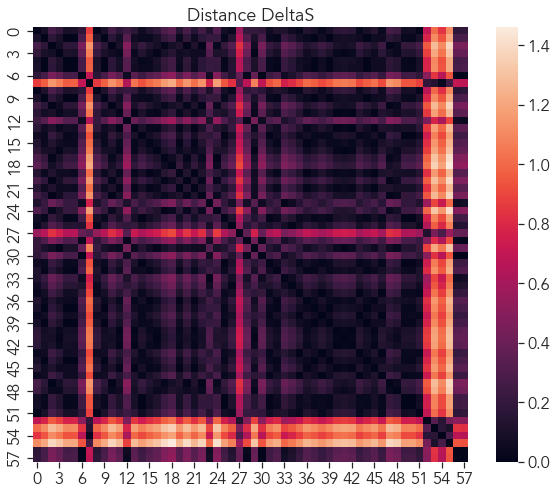

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(MS_norm, square=True, ax=ax)
ax.set_title('Distance DeltaS')

Text(0.5, 1.0, 'Distance T')

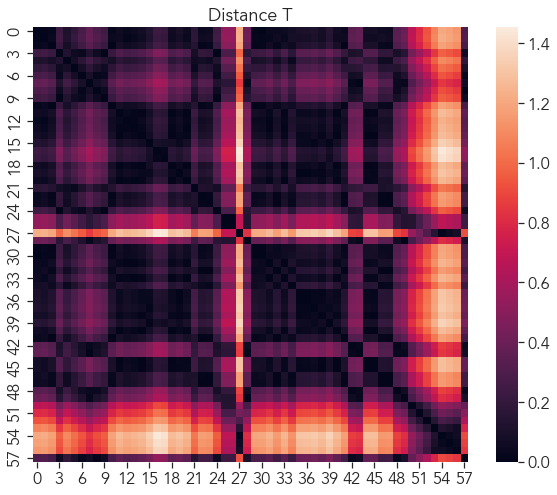

In [57]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(MT_norm, square=True, ax=ax)
ax.set_title('Distance T')

In [59]:
import mantel

In [60]:
result = mantel.test(MS_norm, MT_norm, perms=int(1e4),method='spearman', tail='upper')

In [61]:
if (result.p < 0.05):
    print (result.p)
    print ("Since the p-value is less than 0.05, we can conclude that there is a significant correlation between the two sets of distances.")

0.0001
Since the p-value is less than 0.05, we can conclude that there is a significant correlation between the two sets of distances.


(-0.2, 0.45)

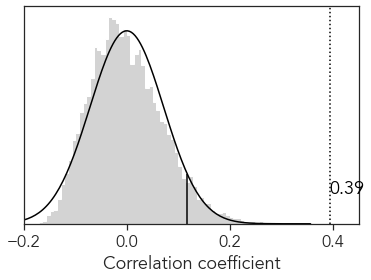

In [62]:
fig, axis = mantel.plot(result)
axis.set_xlim(-0.2,0.45)

## SRF

In [260]:
DS = gdf['DeltaS_SRF'].values
lambdas = gdf['lambda_SRF'].values
alphas = gdf['alpha_SRF'].values
betas = gdf['beta_SRF'].values
rs = gdf['r_SRF'].values
T = gdf['temp_woa'].values
stations = gdf['station'].values

stations = stations[~np.isnan(DS)]
T = T[~np.isnan(DS)]
lambdas = lambdas[~np.isnan(DS)]
alphas = alphas[~np.isnan(DS)]
betas = betas[~np.isnan(DS)]
rs = rs[~np.isnan(DS)]
DS = DS[~np.isnan(DS)]


DS_mean = DS.mean()
T_mean = T.mean()

KeyError: 'lambda_SRF'

In [64]:
MS = np.zeros((len(DS), len(DS)))
MT = np.zeros((len(T), len(T)))
MS_norm = np.zeros((len(DS), len(DS)))
MT_norm = np.zeros((len(T), len(T)))
Mlambda = np.zeros((len(T), len(T)))

for i in range(len(MS)):
    for j in range(len(DS)):
        MS[i,j] = DS[i]-DS[j]
        MT[i,j] = T[i]-T[j]
        Mlambda[i,j] = lambdas[i]-lambdas[j]
        
MS_norm = np.abs(MS)/np.abs(DS_mean)
MT_norm = np.abs(MT)/np.abs(T_mean)

In [65]:
df_Samir = pd.DataFrame([stations, T, lambdas, alphas, betas, rs, DS]).T.rename(columns={
    0:'station',1:'T', 2:'lambda', 3:'alpha', 4:'beta', 5:'r', 6:'DeltaS'})
df_Samir.head()
directory = '/Volumes/GoogleDrive/Il mio Drive/oldmac/tara/downscaling/data/Samir/'
df_Samir.to_csv(directory+'data.csv')

In [57]:
df_MT = pd.DataFrame(MT)
df_MT.to_csv(directory+'distance_T.csv')

df_MT_norm = pd.DataFrame(MT_norm)
df_MT_norm.to_csv(directory+'distance_T_norm.csv')

df_MS_norm = pd.DataFrame(MS_norm)
df_MS_norm.to_csv(directory+'distance_S_norm.csv')

df_Mlambda = pd.DataFrame(Mlambda)
df_Mlambda.to_csv(directory+'distance_lambda.csv')

Text(0.5, 1.0, 'Distance DeltaS')

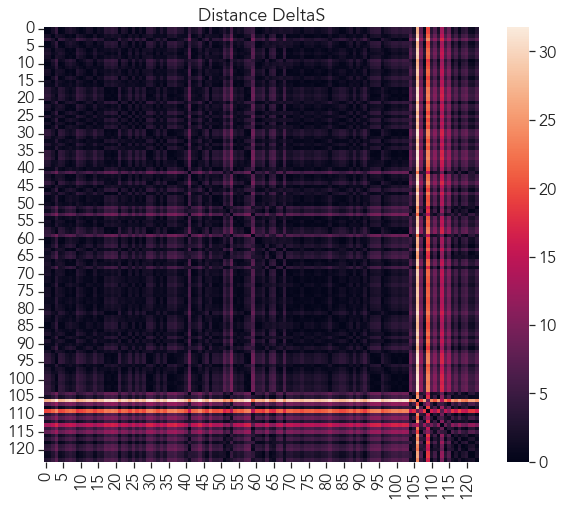

In [58]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(MS_norm, square=True, ax=ax)
ax.set_title('Distance DeltaS')

Text(0.5, 1.0, 'Distance T')

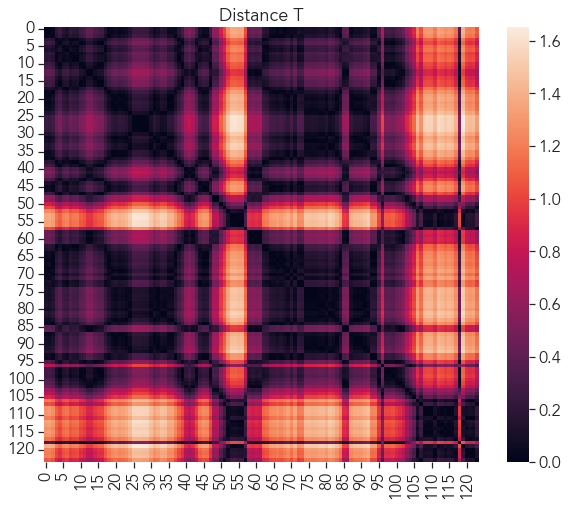

In [59]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(MT_norm, square=True, ax=ax)
ax.set_title('Distance T')

In [60]:
! pip install mantel

In [61]:
import mantel
# https://github.com/jwcarr/mantel

In [62]:
result = mantel.test(MS_norm, MT_norm, perms=int(1e4),method='spearman', tail='upper')

In [63]:
if (result.p < 0.05):
    print (result.p)
    print ("Since the p-value is less than 0.05, we can conclude that there is a significant correlation between the two sets of distances.")

0.0001
Since the p-value is less than 0.05, we can conclude that there is a significant correlation between the two sets of distances.


(-0.2, 0.45)

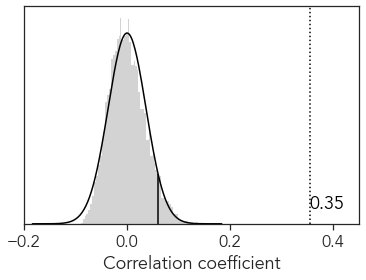

In [64]:
fig, axis = mantel.plot(result)
axis.set_xlim(-0.2,0.45)

In [65]:
# matrice distanze dei lambda e di T
# 

# Evenness and Downscaling

In [299]:
def expected_evenness_pl(alpha, xm, xM):
    num = (xm**2) * (xM**alpha) * (1 - (2-alpha)*np.log(xm)) - (xM**2) * (xm**alpha) * (1 - (2-alpha)*np.log(xM))
    argnum = ((xm**2) * (xM**alpha) - (xM**2) * (xm**alpha)) * (alpha-1)
    argden = ((xm**1) * (xM**alpha) - (xM**1) * (xm**alpha)) * (alpha-2)
    den = ((xm**2) * (xM**alpha) - (xM**2) * (xm**alpha)) * (alpha - 2) * np.log(argnum/argden)
    return num/den

def expected_evenness_pl_S(alpha, xm, xM, S):
    num = (alpha-1)*((xm**2) * (xM**alpha) * (1 - (2-alpha)*np.log(xm)) - (xM**2) * (xm**alpha) * (1 - (2-alpha)*np.log(xM)))
    den = ((xm**1) * (xM**alpha) - (xM**1) * (xm**alpha)) * (alpha - 2)**2
    return -1.*S*num/(den*np.log(S))

In [300]:
relativeAbundances = Abundances/Abundances.sum()

In [301]:
for depth in Depths:
    gdf['xm_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: relativeAbundances.loc[relativeAbundances[x]>0,x].min() if x in relativeAbundances.columns else None)
    gdf['xM_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: relativeAbundances.loc[relativeAbundances[x]>0,x].max() if x in relativeAbundances.columns else None)
    gdf['xmean_{}'.format(depth)] = gdf['station_{}'.format(depth)].apply(lambda x: relativeAbundances.loc[relativeAbundances[x]>0,x].mean() if x in relativeAbundances.columns else None)
    gdf['ExpectedEven_{}'.format(depth)] = gdf[~gdf['xm_{}'.format(depth)].isna()].loc[:,['lambda_{}'.format(depth), 'xm_{}'.format(depth), 'xM_{}'.format(depth)]].apply(lambda x: expected_evenness_pl(x[0], x[1], x[2]), axis=1)
    gdf['ExpectedEvenS_{}'.format(depth)] = gdf[~gdf['xm_{}'.format(depth)].isna()].loc[:,['lambda_{}'.format(depth), 'xm_{}'.format(depth), 'xM_{}'.format(depth), 'Richness_{}'.format(depth)]].apply(lambda x: expected_evenness_pl_S(x[0], x[1], x[2], x[3]), axis=1)
    gdf['ExpectedEvenXmean_{}'.format(depth)] = gdf[~gdf['xm_{}'.format(depth)].isna()].loc[:,['lambda_{}'.format(depth), 'xm_{}'.format(depth), 'xM_{}'.format(depth), 'xmean_{}'.format(depth)]].apply(lambda x: expected_evenness_pl_S(x[0], x[1], x[2], 1./x[3]), axis=1)

/var/folders/c6/wyfkjjbx7951r06nx266f2z80000gn/T/ipykernel_3151/4119105102.py:5: RuntimeWarning: invalid value encountered in double_scalars
  den = ((xm**2) * (xM**alpha) - (xM**2) * (xm**alpha)) * (alpha - 2) * np.log(argnum/argden)
/var/folders/c6/wyfkjjbx7951r06nx266f2z80000gn/T/ipykernel_3151/4119105102.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return -1.*S*num/(den*np.log(S))
/var/folders/c6/wyfkjjbx7951r06nx266f2z80000gn/T/ipykernel_3151/4119105102.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return -1.*S*num/(den*np.log(S))


In [302]:
fitE_SRF = linregress(x=gdf[~gdf['ExpectedEven_SRF'.format(depth)].isna()].loc[:, 'Evenness_SRF'].values, 
                      y=gdf[~gdf['ExpectedEven_SRF'.format(depth)].isna()].loc[:, 'ExpectedEven_SRF'].values)
fitE_DCM = linregress(x=gdf[~gdf['ExpectedEven_DCM'.format(depth)].isna()].loc[:, 'Evenness_DCM'].values, 
                      y=gdf[~gdf['ExpectedEven_DCM'.format(depth)].isna()].loc[:, 'ExpectedEven_DCM'].values)

In [303]:
fitE_SRF.rvalue**2, fitE_SRF.rvalue**1

(0.8957192819586417, 0.9464244724005406)

In [304]:
fitE_DCM.rvalue**2, fitE_DCM.rvalue**1

(0.928083061213697, 0.9633706769534233)

In [305]:
fitE_SRF

LinregressResult(slope=0.7696027995969328, intercept=0.21094058282883316, rvalue=0.9464244724005406, pvalue=2.950462746447077e-60, stderr=0.02407183528344037, intercept_stderr=0.01314854072087249)

In [306]:
fig_dir

'/Volumes/GoogleDrive/Il mio Drive/oldmac/tara/downscaling/fig/'

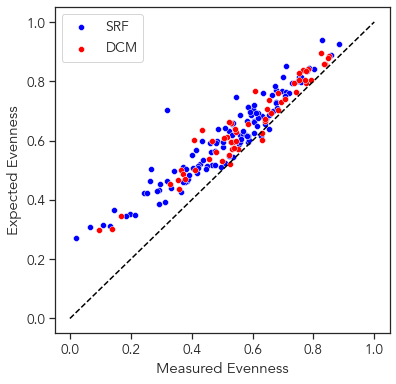

In [307]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(data=gdf, x='Evenness_SRF', y='ExpectedEven_SRF', ax=ax, label='SRF', color='blue')
sns.scatterplot(data=gdf, x='Evenness_DCM', y='ExpectedEven_DCM', ax=ax, label='DCM', color='red')
x = np.linspace(0,1)
ax.plot(x,x+0.,ls ='--', color='black')
ax.set_xlabel('Measured Evenness')
ax.set_ylabel('Expected Evenness')
ax.legend()

fig.savefig(fig_dir  + 'ExpectedEvenness_vs_Evenness.pdf')

In [308]:
fig_dir

'/Volumes/GoogleDrive/Il mio Drive/oldmac/tara/downscaling/fig/'

In [310]:
figsize

(5.096172795238579, 3.149608)

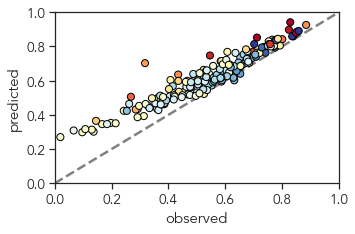

In [490]:
fig, ax = plt.subplots(figsize=figsize)

palette = 'RdYlBu_r'
#palette = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
#sns.color_palette("icefire", as_cmap=True)
#sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
delta = 0.0
norm = clrs.Normalize(vmin=1.0+delta, vmax=2.-delta)
sns.scatterplot(data=gdf, x='Evenness_DCM', y='ExpectedEven_DCM', hue='lambda_DCM', palette=palette,
                hue_norm=norm, lw=1., marker='o', s=50, #fc='none',
                ax=ax, 
                #edgecolor="none" 
                edgecolor='black',
                linewidth=1,
               )
sns.scatterplot(data=gdf, x='Evenness_SRF', y='ExpectedEven_SRF', hue='lambda_SRF', palette=palette,
                hue_norm=norm, lw=1., marker="o", s=50,#fc="none",
                ax=ax,
                                #edgecolor="none" 
                edgecolor='black',
                linewidth=1,
               )

x = np.linspace(0,1)
ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)
#ax.set_xlabel('Measured Evenness')
#ax.set_ylabel('Expected Evenness')
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
ax.set_xlim(0.,1.)
ax.set_ylim(0.,1.)
ax.legend()

sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
#ax.figure.colorbar(sm)

#fig.savefig(fig_dir  + 'ExpectedEvenness_vs_Evenness_lambda.pdf')
fig.savefig(fig_dir  + 'ExpectedEvenness_vs_Evenness_lambda.svg', facecolor='none', edgecolor='none')

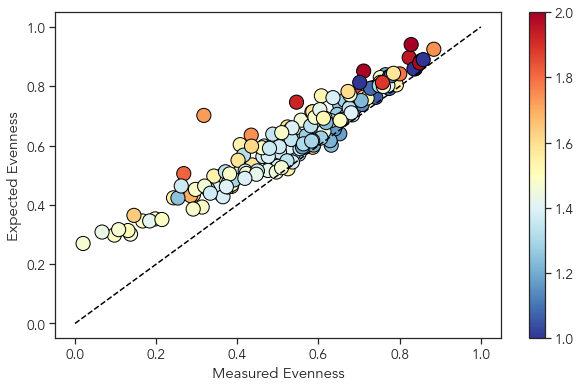

In [309]:
fig, ax = plt.subplots(figsize=(10,6))

palette = 'RdYlBu_r'
#palette = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
#sns.color_palette("icefire", as_cmap=True)
#sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
delta = 0.0
norm = clrs.Normalize(vmin=1.0+delta, vmax=2.-delta)
sns.scatterplot(data=gdf, x='Evenness_DCM', y='ExpectedEven_DCM', hue='lambda_DCM', palette=palette,
                hue_norm=norm, lw=1., marker='o', s=200, #fc='none',
                ax=ax, 
                #edgecolor="none" 
                edgecolor='black',
                linewidth=1,
               )
sns.scatterplot(data=gdf, x='Evenness_SRF', y='ExpectedEven_SRF', hue='lambda_SRF', palette=palette,
                hue_norm=norm, lw=1., marker="o", s=200,#fc="none",
                ax=ax,
                                #edgecolor="none" 
                edgecolor='black',
                linewidth=1,
               )

x = np.linspace(0,1)
ax.plot(x,x+0.,ls ='--', color='black')
ax.set_xlabel('Measured Evenness')
ax.set_ylabel('Expected Evenness')
ax.legend()

sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

fig.savefig(fig_dir  + 'ExpectedEvenness_vs_Evenness_lambda.pdf')
fig.savefig(fig_dir  + 'ExpectedEvenness_vs_Evenness_lambda.svg')

In [321]:
def expectedEvenness_pl(alpha, xm, xM):
    result = (xm**2 * xM**alpha * (1 + (-2 + alpha) * np.log(xm)) - xm**alpha * xM**2 * (1 + (-2 + alpha) * np.log(xM)))/((-xm**alpha * xM**2 + xm**2 * xM**alpha) * (-2 + alpha) * np.log(((-xm**alpha * xM**2 + xm**2 * xM**alpha) * (-1 + alpha))/((-xm**alpha * xM + xm * xM**alpha) * (-2 + alpha))))
    return result

In [335]:
gdf.columns

Index(['station', 'latitude', 'longitude', 'depth_category', 'depth_nominal',
       'month', 'SSD', 'temp_woa', 'sal_woa', 'no3_woa', 'po4_woa',
       'sioh4_woa', 'dco', 'dcu', 'dfe', 'dzn', 'geometry', 'station_SRF',
       'TotAbundance_SRF', 'Richness_SRF', 'Shannon_SRF', 'Evenness_SRF',
       'station_DCM', 'TotAbundance_DCM', 'Richness_DCM', 'Shannon_DCM',
       'Evenness_DCM', 'region', 'DeltaS_SRF', 'DeltaS_DCM', 'lambda_SRF',
       'alpha_SRF', 'beta_SRF', 'r_SRF', 'lambda_DCM', 'alpha_DCM', 'beta_DCM',
       'r_DCM', 'xm_SRF', 'xM_SRF', 'xmean_SRF', 'ExpectedEven_SRF',
       'ExpectedEvenS_SRF', 'ExpectedEvenXmean_SRF', 'xm_DCM', 'xM_DCM',
       'xmean_DCM', 'ExpectedEven_DCM', 'ExpectedEvenS_DCM',
       'ExpectedEvenXmean_DCM'],
      dtype='object')

In [388]:
gdf['xm_SRF'].values

array([1.31821777e-04, 1.26742712e-03, 5.29100529e-03, 1.53609831e-03,
       2.48756219e-03, 3.39328130e-04, 1.51515152e-02, 4.63606861e-04,
       3.33333333e-01, 1.31960940e-04, 2.31481481e-03, 3.89120199e-05,
       7.02839471e-05, 8.00192046e-05, 4.35123140e-05, 7.65579544e-05,
       3.53481796e-04, 1.15340254e-03, 5.08905852e-04, 1.96850394e-03,
       1.83150183e-04, 1.62802813e-05, 3.52112676e-03, 1.94950775e-05,
       1.40964195e-04, 5.36480687e-04, 3.95898492e-05, 5.88235294e-03,
       2.08794421e-05, 1.41442716e-03, 1.16076611e-04, 1.98412698e-03,
       2.62950302e-04, 1.32450331e-03, 1.17302053e-04, 1.47383935e-04,
       7.22543353e-04, 2.45700246e-03, 3.69713103e-05, 1.96672305e-05,
       2.77269450e-05, 4.93120963e-05, 3.40599455e-04, 3.80952381e-04,
       5.31914894e-03, 1.06157113e-03, 8.21018062e-04, 5.19210800e-04,
       3.82379933e-05, 4.57038391e-04, 9.64106322e-06, 3.60997798e-05,
       6.04375680e-06, 3.69251675e-06, 2.78937694e-06, 2.12097624e-06,
      

In [350]:
gdf['xM_SRF'].values

array([0.243343  , 0.41951838, 0.42328042, 0.31029186, 0.20149254,
       0.18730913, 0.43939394, 0.40611961, 0.33333333, 0.56096595,
       0.4537037 , 0.36880812, 0.19686534, 0.38561255, 0.57988861,
       0.46095544, 0.21915871, 0.20645905, 0.38982188, 0.16338583,
       0.16062271, 0.58275267, 0.23943662, 0.16297885, 0.54820975,
       0.29077253, 0.20519419, 0.41764706, 0.32705558, 0.22347949,
       0.34335461, 0.38690476, 0.20063108, 0.28344371, 0.06956012,
       0.09491525, 0.08815029, 0.0958231 , 0.17180568, 0.18203989,
       0.52980647, 0.2975985 , 0.27043597, 0.23961905, 0.10106383,
       0.33970276, 0.58128079, 0.34215992, 0.25367085, 0.40265082,
       0.60961407, 0.40244035, 0.32068778, 0.7397108 , 0.50182286,
       0.81497876, 0.51193996, 0.5976458 , 0.16176471, 0.69672131,
       0.25376965, 0.55546392, 0.39683544, 0.48963731, 0.84375   ,
       0.36220472, 0.26566416, 0.53846154, 0.18304244, 0.43459558,
       0.28729473, 0.3562631 , 0.43427508, 0.35688141,        

0.99


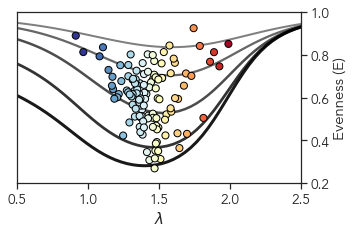

In [590]:
fig, ax = plt.subplots(figsize=figsize)

alpha = np.linspace(0.5,2.5)
xm = 1e-6
xM = 0.001
y = expectedEvenness_pl(alpha, xm, xM)#
ax.plot(alpha, y, color='black', lw=2, zorder=-100, alpha=0.5)

xm = 1e-6
xM = 0.01
y = expectedEvenness_pl(alpha, xm, xM)#
ax.plot(alpha, y, color='black', lw=2.25, zorder=-100, alpha=0.6)

xm = 1e-6
xM = 0.1
y = expectedEvenness_pl(alpha, xm, xM)#
ax.plot(alpha, y, color='black', lw=2.5, zorder=-100, alpha=0.7)

xm = 1e-6
xM = 0.5
y = expectedEvenness_pl(alpha, xm, xM)#
ax.plot(alpha, y, color='black', lw=2.75, zorder=-100, alpha=0.8)

xm = 1e-6
xM = 1-1e-2
print(xM)
y = expectedEvenness_pl(alpha, xm, xM)
ax.plot(alpha, y, color='black', lw=3., zorder=-100, alpha=0.9)

sns.scatterplot(data=gdf.loc[gdf['xM_SRF']>=0], x='lambda_SRF', y='ExpectedEven_SRF', hue='lambda_SRF', ax=ax,
                palette=palette,  s=50,
                hue_norm=norm,
                edgecolor='black',
                linewidth=1,
                #hue ='TotAbundance_SRF',
                #hue_norm = clrs.LogNorm(),
                legend = False,
                #palette = sns.light_palette("grey", as_cmap=True)
                #palette = sns.color_palette("gray_r", as_cmap=True)
                #color='lightgrey'
               )

ax.set_xlim(0.5, 2.5)
ax.set_ylim(0.2, 1.0)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Evenness (E)')

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.gca().yaxis.set_ticks_position('right')


fig.savefig(fig_dir  + 'ExpectedEvenness_vs_lambda.svg', facecolor='none', edgecolor='none')

In [328]:
alpha = np.linspace(0.5,2.5)
xm = 1e-13
xM = 1e-3
y = expectedEvenness_pl(alpha, xm, xM)

In [329]:
y

array([0.94605092, 0.94161123, 0.93654493, 0.93071603, 0.9239479 ,
       0.91600947, 0.906599  , 0.89532892, 0.8817218 , 0.86523809,
       0.84536479, 0.82178396, 0.79458494, 0.76440186, 0.73234511,
       0.69972825, 0.667752  , 0.6373109 , 0.60895981, 0.58297902,
       0.55946663, 0.53841937, 0.51979149, 0.50353494, 0.48962775,
       0.47809707, 0.4690424 , 0.46266378, 0.45929907, 0.45947304,
       0.46395583, 0.47381516, 0.49041619, 0.51527465, 0.54962767,
       0.59365434, 0.64559471, 0.70147561, 0.75609882, 0.80491299,
       0.84542982, 0.87733921, 0.90171059, 0.92010118, 0.93400071,
       0.94461458, 0.9528413 , 0.95932475, 0.96451972, 0.96874745])

(array([13., 15., 10.,  5.,  4.,  4.,  3.,  1.,  1.,  2.]),
 array([0.09197787, 0.17169858, 0.2514193 , 0.33114001, 0.41086072,
        0.49058144, 0.57030215, 0.65002286, 0.72974358, 0.80946429,
        0.889185  ]),
 <BarContainer object of 10 artists>)

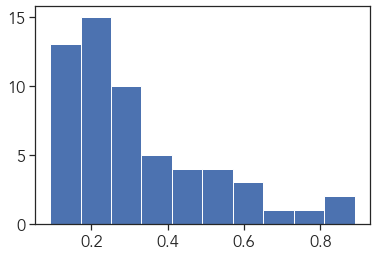

In [77]:
plt.hist(gdf['xM_DCM'])

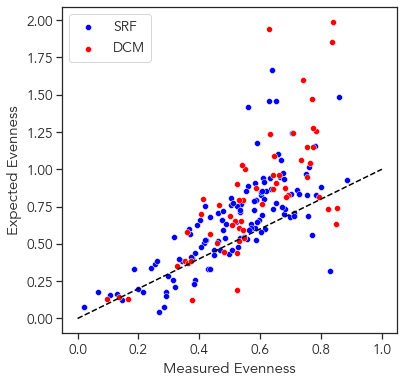

In [131]:
fig, ax = plt.subplots(figsize=(6,6))

sns.scatterplot(data=gdf, x='Evenness_SRF', y='ExpectedEvenXmean_SRF', ax=ax, label='SRF', color='blue')
sns.scatterplot(data=gdf, x='Evenness_DCM', y='ExpectedEvenXmean_DCM', ax=ax, label='DCM', color='red')
x = np.linspace(0,1)
ax.plot(x,x,ls ='--', color='black')
ax.set_xlabel('Measured Evenness')
ax.set_ylabel('Expected Evenness')
ax.legend()

In [132]:
gdf[~gdf['xm_{}'.format(depth)].isna()].loc[:,['lambda_{}'.format(depth), 'xm_{}'.format(depth), 'xM_{}'.format(depth)]].apply(lambda x: expected_evenness_pl(x[0], x[1], x[2]), axis=1)

0      0.593817
1      0.792689
2      0.896844
4      0.795536
6      0.657599
7      0.550183
11     0.562479
12     0.521851
14     0.530239
16     0.760956
18     0.802940
20     0.729847
21     0.435169
22     0.703677
23     0.601282
24     0.738743
25     0.858959
29     0.858430
31     0.884803
32     0.664968
36     0.804559
38     0.624819
45     0.840516
46     0.598479
47     0.878579
48     0.694258
49     0.662760
53     0.467716
61     0.613326
66     0.839064
68     0.595910
69     0.500908
70     0.628444
71     0.502174
73     0.569946
84     0.597092
85     0.671557
89     0.571095
90     0.573870
91     0.736417
93     0.609134
94     0.762540
95     0.829314
96     0.638663
98     0.705133
99     0.833616
103    0.536247
104    0.805338
111    0.635184
112    0.603147
114    0.767731
115    0.656125
117    0.452461
121    0.301408
122    0.298160
123    0.345680
126    0.487740
128    0.471330
dtype: float64

# All versus only diatoms

In [392]:
df = pd.read_csv("../data/Exponents.csv",
                index_col=0)

In [395]:
df["lambda_diatoms"] = - df["lambda"]
df["lambda_whole"] = - df["esg.lambda"]
df["lambda_diatoms_ML"] = df["station"].apply(lambda x: alpha_dict[x] if x in alpha_dict.keys() else np.nan)

In [396]:
df

station  vec_estimated_k  vec_estimated_l    lambda  esg.vec_estimated_k   
1        175         0.446619        -0.022956 -1.469575             0.439476  \
2        188         0.529419         0.018229 -1.511190             0.594883   
3        205         0.298108        -0.180625 -1.478733                  NaN   
4        193         0.247279        -0.224247 -1.471526             0.567959   
5         87         0.689489         0.045035 -1.644454             0.452321   
..       ...              ...              ...       ...                  ...   
132      118              NaN              NaN       NaN             0.473852   
133      119              NaN              NaN       NaN             0.521088   
134      120              NaN              NaN       NaN             0.563985   
135      121              NaN              NaN       NaN             0.260900   
136       19              NaN              NaN       NaN             0.151839   

     esg.vec_estimated_l  esg.lambda  lambda_diatoms  lambda_whole   
1              -0.127190   -1.566666        1.469575      1.566666  \
2              -0.004746   -1.599629        1.511190      1.599629   
3                    NaN         NaN        1.478733           NaN   
4              -0.065153   -1.633112        1.471526      1.633112   
5              -0.123566   -1.575887        1.644454      1.575887   
..                   ...         ...             ...           ...   
132            -0.234999   -1.708850             NaN      1.708850   
133            -0.170195   -1.691284             NaN      1.691284   
134            -0.104054   -1.668039             NaN      1.668039   
135            -0.253690   -1.514591             NaN      1.514591   
136            -0.325493   -1.477333             NaN      1.477333   

     lambda_diatoms_ML  
1             1.564120  
2             1.575859  
3             1.631053  
4             1.639249  
5             1.767699  
..                 ...  
132                NaN  
133                NaN  
134                NaN  
135                NaN  
136                inf  

[136 rows x 10 columns]

In [397]:
x = df["lambda_diatoms"].values
y = df["lambda_whole"].values

x1 = x[((x>0) & (y>0))]
y1 = y[((x>0) & (y>0))]

In [398]:
linrg = linregress(y=y1, x=x1)
print(linrg)

LinregressResult(slope=0.09846427189271498, intercept=1.4133467007344416, rvalue=0.24779128286640034, pvalue=0.00682271466901471, stderr=0.03574405418071034, intercept_stderr=0.05211292349011619)


0.24779128286640034


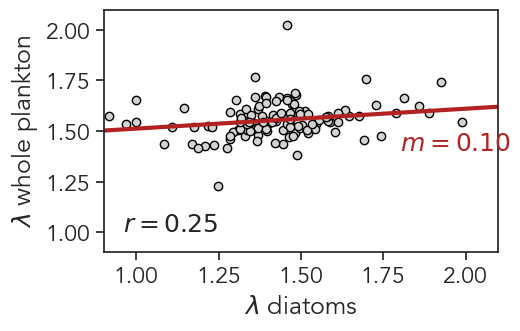

In [399]:
fig, ax = plt.subplots(figsize=figsize)

sns.scatterplot(data=df, x='lambda_diatoms', y='lambda_whole', 
                color='lightgrey',
                lw=1., #marker='o', #s=150,
                edgecolor='black',
                linewidth=1,
                label = r"$r={0:1.2f}$".format(linrg.rvalue),
                legend=False,
                ax=ax)

ax.set_ylim((.9,2.1))
ax.set_xlim((.9,2.1))
ax.set_xlabel("$\lambda$ diatoms")
ax.set_ylabel("$\lambda$ whole plankton")
#ax.legend(loc='upper left')

x_axis = np.linspace(0.8,2.1)
y_axis = linrg.intercept+linrg.slope*x_axis
ax.plot(x_axis, y_axis, lw=3, ls='-', color='firebrick')
ax.text(0.96,1,'$r = {0:1.2f}$'.format(linrg.rvalue))
ax.text(1.8,1.4,'$m = {0:1.2f}$'.format(linrg.slope), color='firebrick')

x = np.linspace(0,4)
#ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)

print(linrg.rvalue)

plt.show()
fig.tight_layout()
fig.savefig(fig_dir  + 'lambda_scatter.pdf')
fig.savefig(fig_dir  + 'lambda_scatter.svg')

(1.0, 3.0)

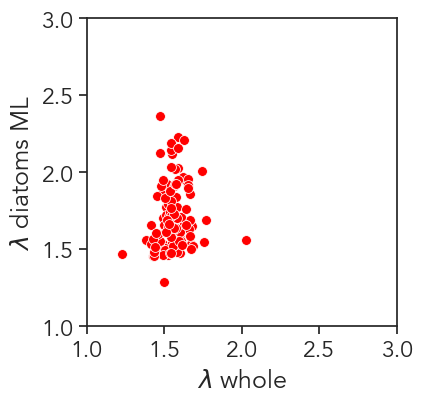

In [405]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(x=df["lambda_whole"], y=df["lambda_diatoms_ML"], ax=ax, color='red', lw=1., marker='o', s=50)
ax.set_xlabel(r'$\lambda$ whole')
ax.set_ylabel(r'$\lambda$ diatoms ML')
ax.set_xlim(1.,3)
ax.set_ylim(1.,3)

In [592]:
df["lambda_diatoms"]

1      1.469575
2      1.511190
3      1.478733
4      1.471526
5      1.644454
         ...   
132         NaN
133         NaN
134         NaN
135         NaN
136         NaN
Name: lambda_diatoms, Length: 136, dtype: float64

In [595]:
gdf.columns

Index(['station', 'latitude', 'longitude', 'depth_category', 'depth_nominal',
       'month', 'SSD', 'temp_woa', 'sal_woa', 'no3_woa', 'po4_woa',
       'sioh4_woa', 'dco', 'dcu', 'dfe', 'dzn', 'geometry', 'station_SRF',
       'TotAbundance_SRF', 'Richness_SRF', 'Shannon_SRF', 'Evenness_SRF',
       'station_DCM', 'TotAbundance_DCM', 'Richness_DCM', 'Shannon_DCM',
       'Evenness_DCM', 'region', 'DeltaS_SRF', 'DeltaS_DCM', 'lambda_SRF',
       'alpha_SRF', 'beta_SRF', 'r_SRF', 'lambda_DCM', 'alpha_DCM', 'beta_DCM',
       'r_DCM', 'xm_SRF', 'xM_SRF', 'xmean_SRF', 'ExpectedEven_SRF',
       'ExpectedEvenS_SRF', 'ExpectedEvenXmean_SRF', 'xm_DCM', 'xM_DCM',
       'xmean_DCM', 'ExpectedEven_DCM', 'ExpectedEvenS_DCM',
       'ExpectedEvenXmean_DCM'],
      dtype='object')

In [609]:
gdf['deviations_lambda_SRF'] = gdf['lambda_SRF']-1.5

(-0.52, 0.52)

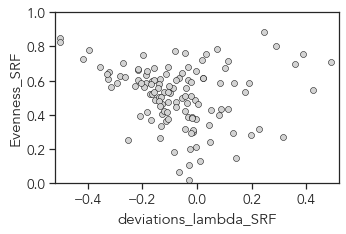

In [615]:
fig, ax = plt.subplots(figsize=figsize)

sns.scatterplot(data=gdf, y="Evenness_SRF", x="deviations_lambda_SRF", ax=ax,
               lw=1, edgecolor='black', color='lightgrey'
               )

ax.set_ylim(0., 1.)
ax.set_xlim(-0.52, .52)

# Richness 0-th order

In [5]:
#abundance_file = '/Volumes/GoogleDrive/Il mio Drive/data/tara/downscaling/data/Abundance.csv'
#abundance_file = '/Volumes/GoogleDrive/Il mio Drive/data/tara/filterDownscaling/metaB/Abundances.csv'
abundance_file = "/Users/epigani/Library/CloudStorage/GoogleDrive-emanuele.pigani.1@unipd.it/Il mio Drive/data/tara/filterDownscaling/metaB/Abundances.csv"
#Abundances = pd.read_csv(raw_file, sep=' ', index_col=0, header=0)
#Abundances.rename(columns = {c: c.split('_')[1]+'_'+c.split('_')[2] for c in Abundances.columns}, inplace=True)
#Abundances.to_csv(abundance_file)
Abundances = pd.read_csv(abundance_file, index_col=0, header=0)

Normalized_Abundances = Abundances/Abundances.sum(axis=0)

Depths = {d: [c for c in Abundances.columns if c[-3:]==d] for d in ['SRF','DCM']}
Stations = np.unique([int(c.split('_')[0]) for c in Abundances[Abundances.sum(axis=1)>0].columns])
print (' Number of stations: {} \n Number of different OTUs: {}'.format(len(Stations), len(Abundances)))
print ('\n Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(Depths['SRF']),len(Depths['DCM'])))

Abundances.head(3)

 Number of stations: 125 
 Number of different OTUs: 5830

 Number of stations SRF: 125 
 Number of stations DCM: 58


158_SRF  188_SRF  194_SRF  194_DCM  168_DCM  \
0007584343baed6a66bc624ab07afa51        0        0        0        0        0   
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        2        0        0   

                                  206_SRF  191_SRF  180_DCM  196_SRF  173_SRF  \
0007584343baed6a66bc624ab07afa51        0        0        0        0        0   
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        5        0        0        0        0   

                                  ...  150_DCM  150_SRF  151_DCM  151_SRF  \
0007584343baed6a66bc624ab07afa51  ...        0        0        0        0   
000d7f48a59463756281b4ea64af743f  ...        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a  ...        0        0        0        0   

                                  152_SRF  047_DCM  047_SRF  049_SRF  078_SRF  \
0007584343baed6a66bc624ab07afa51        0        0        0        0        0   
000d7f48a59463756281b4ea64af743f        0        0        0        0        0   
001dedda63f65dd120ccef5ed9eff10a        0        0        0        0        0   

                                  078_DCM  
0007584343baed6a66bc624ab07afa51        0  
000d7f48a59463756281b4ea64af743f        0  
001dedda63f65dd120ccef5ed9eff10a        0  

[3 rows x 183 columns]

In [8]:
N = Abundances.sum(axis=0)
S = (Abundances>0).sum(axis=0)


Text(0.5, 1.0, 'Number of OTUs vs Number of reads')

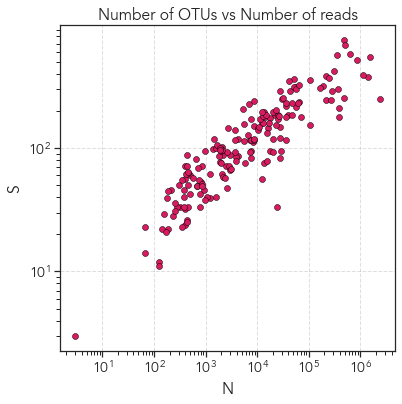

In [21]:
# scatterplot of N vs S
figsize = (6,6)
color = '#D81B60'
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(y=S, x=N, ax=ax, color=color, edgecolor='black', lw=1)
ax.set_ylabel('S')
ax.set_xlabel('N')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which='major', axis='both', linestyle='--', color='grey', alpha=0.25)
ax.set_title('Number of OTUs vs Number of reads')

In [45]:
Sref = S['173_SRF']
Nref = N['173_SRF']

Sloc = Sref/Nref * N

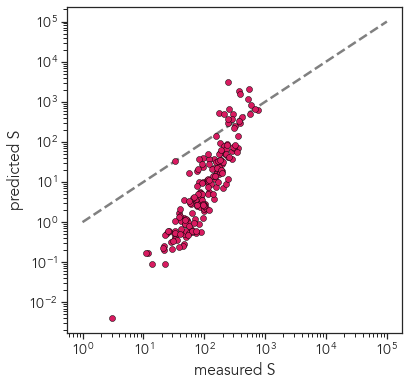

In [46]:
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(y=Sloc, x=S, ax=ax, color=color, edgecolor='black', lw=1)
ax.set_ylabel('predicted S')
ax.set_xlabel('measured S')
ax.set_xscale('log')
ax.set_yscale('log')

# draw a diagonal line
x = np.linspace(1,1e5)
ax.plot(x,x+0.,ls ='--', color='grey', lw=2.5, zorder=-100)

# Prepare a latex table

In [521]:
latex_df = fitBruno.copy()
latex_df.set_index('station', inplace=True)
latex_df = latex_df[['alpha', 'beta', 'r', 'vec_ksmod_pvalue']]
latex_df.columns = ['alpha', 'beta', 'r', 'p-value']
# sort by index
latex_df.sort_index(inplace=True)

# latex_df.to_latex(fig_dir + 'fitBruno.tex')

In [522]:
latex_df['alpha'] = latex_df['alpha'].map(lambda x: str(round(x, 2)))
latex_df['beta'] = latex_df['beta'].map(lambda x: str(round(x, 2)))
latex_df['r'] = latex_df['r'].map(lambda x: '{:0.2e}'.format(x))
latex_df['p-value'] = latex_df['p-value'].map(lambda x: '{:0.2e}'.format(x))

latex_df

alpha   beta         r   p-value
station                                  
007_DCM   -0.2   0.21  0.00e+00  0.00e+00
007_SRF  -0.46  -0.13  0.00e+00  0.00e+00
008_DCM   0.03   0.13  1.13e-02  2.05e-01
008_SRF   0.02   0.39  0.00e+00  0.00e+00
010_DCM   0.45    1.4  0.00e+00  2.35e-01
...        ...    ...       ...       ...
205_SRF  -0.18    0.3  0.00e+00  0.00e+00
206_SRF   0.67   1.16  0.00e+00  0.00e+00
208_SRF   0.01    0.4  0.00e+00  0.00e+00
209_SRF   0.31   0.79  0.00e+00  0.00e+00
210_SRF  -0.18   0.21  0.00e+00  0.00e+00

[182 rows x 4 columns]

In [523]:
latex_table = latex_df.to_latex(index=True, escape=True)

# Save LaTeX table to a file
with open(fig_dir + 'table.tex', 'w') as f:
    f.write(latex_table)

In [526]:
latex_df.columns = ['\\alpha', '\\beta', 'r', 'p-value']
latex_df

\alpha  \beta         r   p-value
station                                  
007_DCM   -0.2   0.21  0.00e+00  0.00e+00
007_SRF  -0.46  -0.13  0.00e+00  0.00e+00
008_DCM   0.03   0.13  1.13e-02  2.05e-01
008_SRF   0.02   0.39  0.00e+00  0.00e+00
010_DCM   0.45    1.4  0.00e+00  2.35e-01
...        ...    ...       ...       ...
205_SRF  -0.18    0.3  0.00e+00  0.00e+00
206_SRF   0.67   1.16  0.00e+00  0.00e+00
208_SRF   0.01    0.4  0.00e+00  0.00e+00
209_SRF   0.31   0.79  0.00e+00  0.00e+00
210_SRF  -0.18   0.21  0.00e+00  0.00e+00

[182 rows x 4 columns]

In [527]:
df1 = latex_df.iloc[:45]
df2 = latex_df.iloc[45:90]
df3 = latex_df.iloc[90:135]
df4 = latex_df.iloc[135:]

# Create LaTeX tables
latex_table1 = df1.to_latex(index=True, escape=True)
latex_table2 = df2.to_latex(index=True, escape=True)
latex_table3 = df3.to_latex(index=True, escape=True)
latex_table4 = df4.to_latex(index=True, escape=True)

# Save LaTeX tables to separate files
with open(fig_dir +'table1.tex', 'w') as f:
    f.write(latex_table1)

with open(fig_dir +'table2.tex', 'w') as f:
    f.write(latex_table2)
    
with open(fig_dir +'table3.tex', 'w') as f:
    f.write(latex_table3)

with open(fig_dir +'table4.tex', 'w') as f:
    f.write(latex_table4)



In [507]:
len((df1))

91